# Assessment 02

Eurico Martins (nº. 8794, a8794@alunos.ipca.pt)
Gutelvam Fernandes (nº. 33791,  a33791@alunos.ipca.pt)

In [1]:
%pip install tabulate
%pip install scikit-learn
%pip install mlxtend
%pip install seaborn
%pip install numpy
%pip install scipy
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from enum import Enum

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import seaborn as sns
import networkx as nx

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from mlxtend.frequent_patterns import apriori, association_rules

In [3]:
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

## Data Preparation

In [4]:
class MissingValuesStrategy(Enum):
	MEAN="mean"
	MEDIAN = "median"
	MODE = "mode"
	CONSTANT = "constant"

In [5]:
class DataClassification(Enum):
	NUMERICAL = "numerical"
	CATEGORICAL = "categorical"

In [6]:
class DataPreparation:
	def __init__(self, file_path=None, target_column=None):
		if not file_path:
			raise ValueError("Either 'file_path' or 'dataframe' must be provided.")

		self.df = pd.read_csv(file_path)
		self.summary()
		
		self.original_df = self.df.copy(True)
		self.target_column = target_column

		if self.target_column and self.target_column not in self.df.columns:
			raise ValueError(f"Target column '{target_column}' not found in the dataset.")
		

	def drop_columns(self, columns_to_drop):
		if not isinstance(columns_to_drop, list):
				raise ValueError("columns_to_drop should be a list of column names.")

		# Check if any columns in the list do not exist in the DataFrame
		existing_columns = [col for col in columns_to_drop if col in self.df.columns]

		# Drop the columns from the DataFrame
		if existing_columns:
				self.df.drop(columns=existing_columns, inplace=True)
				print(f"Columns {', '.join(existing_columns)} dropped successfully.")


	def handle_missing_values(self,
													data_type: DataClassification = DataClassification.NUMERICAL,
													strategy:MissingValuesStrategy = MissingValuesStrategy.MEAN,
													fill_value=None,
													missing_threshold=None):
		
		if missing_threshold is not None:
			if not (0 <= missing_threshold <= 1):
				raise ValueError("missing_threshold must be a float between 0 and 1.")

			# Identify columns exceeding the missing threshold
			missing_percentages = self.df.isnull().mean()
			columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index.tolist()
			if columns_to_drop:
				self.df.drop(columns=columns_to_drop, inplace=True)
				print(f"Dropped columns exceeding {missing_threshold*100:.2f}% missing data: {columns_to_drop}")
	
		for column in self.df.columns:
			if self.df[column].isnull().sum() > 0:				
				if data_type != DataClassification.CATEGORICAL and strategy == MissingValuesStrategy.MEAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].mean(), inplace=True)
				elif data_type != DataClassification.CATEGORICAL and strategy == MissingValuesStrategy.MEDIAN and self.df[column].dtype in ["float64", "int64"]:
					self.df[column].fillna(self.df[column].median(), inplace=True)
				elif strategy == MissingValuesStrategy.MODE:
					self.df[column].fillna(self.df[column].mode()[0], inplace=True)
				elif strategy == MissingValuesStrategy.CONSTANT:
					self.df[column].fillna(fill_value, inplace=True)


	def encode_categorical(self, drop_first=True, prefix_sep="_"):
		categorical_columns = self.df.select_dtypes(include=["object", "category"]).columns
		
		if not categorical_columns.any():
				print("No categorical columns to encode.")
				return

		# One-hot encoding using pandas get_dummies
		self.df = pd.get_dummies(self.df, columns=categorical_columns, drop_first=drop_first, prefix_sep=prefix_sep)
		print(f"One-hot encoding applied to columns: {', '.join(categorical_columns)}")



	def get_features_and_target(self):
		if not self.target_column:
			raise ValueError("Target column is not specified.")
		X = self.df.drop(columns=[self.target_column])
		y = self.df[self.target_column]
		return X, y


	def scale_features(self):
		columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		scaler = MinMaxScaler()
		self.df[columns] = scaler.fit_transform(self.df[columns])


	def remove_outliers(self, columns=None, factor=1.5, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Determine if the data is skewed or normal
		skewed_columns = self._detect_distribution(columns)
		if skewed_columns:
				print(f"Using IQR method for skewed columns: {skewed_columns}")
				rows_removed = self._remove_outliers_iqr(columns=skewed_columns, factor=factor)
		else:
				print("Using Z-score method for normally distributed columns.")
				rows_removed = self._remove_outliers_zscore(columns=columns, threshold=threshold)

		print(f"Rows removed: {rows_removed}")

	def remove_duplicates(self, subset=None, keep="first"):
		rows_before = len(self.df)
		self.df.drop_duplicates(subset=subset, keep=keep, inplace=True)
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		print(f"Rows removed due to duplicates: {removed_rows}")
		return removed_rows


	def plot_distributions(self):
		# Distribution plots for numerical features
		numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		n_cols = 3  # Number of plots in each row
		n_rows = (len(numerical_columns) // n_cols) + (1 if len(numerical_columns) % n_cols else 0)

		# Adjust the plot size
		plt.figure(figsize=(12, 4 * n_rows))
		for idx, column in enumerate(numerical_columns):
				plt.subplot(n_rows, n_cols, idx + 1)
				sns.histplot(self.df[column], kde=True, bins=30)
				plt.title(f'Distribution of {column}')
		# Apply tight layout for better spacing
		plt.tight_layout()
		plt.show()

	def normality_test_with_plots(self, columns=None):
		# Select all numerical columns if `columns` is None
		if columns is None:
			columns = self.df.select_dtypes(include=["int64", "float64"]).columns

		# Check if no columns are available for testing
		if columns.empty:
			print("No numerical columns to test.")
			return

		# Loop through each column
		for column in columns:
			print(f"\nNormality Tests for Column: {column}")

			# Perform Shapiro-Wilk Test
			stat_shapiro, p_value_shapiro = stats.shapiro(self.df[column].dropna())
			print(f"Shapiro-Wilk Test: statistic={stat_shapiro:.4f}, p-value={p_value_shapiro:.4f}")

			# Perform Kolmogorov-Smirnov Test
			stat_ks, p_value_ks = stats.kstest(
					self.df[column].dropna(), 
					'norm', 
					args=(self.df[column].mean(), self.df[column].std())
			)
			print(f"Kolmogorov-Smirnov Test: statistic={stat_ks:.4f}, p-value={p_value_ks:.4f}")

			# Calculate statistics
			mean_val = self.df[column].mean()
			median_val = self.df[column].median()
			mode_val = self.df[column].mode().iloc[0] if not self.df[column].mode().empty else None

			# Create subplots (1 row, 3 columns)
			_, axes = plt.subplots(1, 3, figsize=(18, 6))

			# Plot Histogram and KDE
			sns.histplot(self.df[column], kde=True, color='blue', bins=30, ax=axes[0], stat="density")
			axes[0].axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
			axes[0].axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
			if mode_val is not None:
					axes[0].axvline(mode_val, color='purple', linestyle='--', label=f"Mode: {mode_val:.2f}")
			axes[0].legend()
			axes[0].set_title(f"Histogram and KDE of {column}", fontsize=14)
			axes[0].set_xlabel(column, fontsize=12)
			axes[0].set_ylabel("Density", fontsize=12)

			# Q-Q Plot
			stats.probplot(self.df[column].dropna(), dist="norm", plot=axes[1])
			axes[1].set_title(f"Q-Q Plot of {column}", fontsize=14)

			# Boxplot
			sns.boxplot(x=self.df[column], color='orange', ax=axes[2])
			axes[2].axvline(mean_val, color='red', linestyle='--', label=f"Mean: {mean_val:.2f}")
			axes[2].axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.2f}")
			if mode_val is not None:
					axes[2].axvline(mode_val, color='purple', linestyle='--', label=f"Mode: {mode_val:.2f}")
			axes[2].legend()
			axes[2].set_title(f"Boxplot of {column}", fontsize=14)
			axes[2].set_xlabel(column, fontsize=12)

			# Adjust layout to avoid overlap
			plt.tight_layout()
			plt.show()

	def plot_correlation_matrix(self, columns=None, annot=True, cmap="coolwarm"):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		# Calculate the correlation matrix
		correlation_matrix = self.df[columns].corr()

		plt.figure(figsize=(10, 6))
		sns.heatmap(correlation_matrix, annot=annot, cmap=cmap, fmt='.2f', linewidths=0.5, cbar=True)
		plt.title("Correlation Matrix")
		plt.show()

	def normality_test(self, columns=None):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns
		
		for column in columns:
			stat_shapiro, p_value_shapiro = stats.shapiro(self.df[column].dropna())
			print(f"Shapiro-Wilk Test for {column}: stat={stat_shapiro}, p-value={p_value_shapiro}")

			stat_ks, p_value_ks = stats.kstest(self.df[column].dropna(), 'norm', args=(self.df[column].mean(), self.df[column].std()))
			print(f"Kolmogorov-Smirnov Test for {column}: stat={stat_ks}, p-value={p_value_ks}")

			# Plot histogram with KDE and normal distribution fit for visual inspection
			plt.figure(figsize=(10, 6))
			sns.histplot(self.df[column], kde=True, bins=30, color='blue', stat="density")
			min_value, max_value = self.df[column].min(), self.df[column].max()
			x = np.linspace(min_value, max_value, 100)
			y = stats.norm.pdf(x, loc=self.df[column].mean(), scale=self.df[column].std())
			plt.plot(x, y, color='red', label='Normal Distribution Fit')
			plt.title(f'{column} Distribution with Normality Test')
			plt.legend()
			plt.show()


	def compare_histograms(self):
			# Original data vs current data (after processing)
			numerical_columns = self.df.select_dtypes(include=["float64", "int64"]).columns
			for column in numerical_columns:
					plt.figure(figsize=(10, 6))
					sns.histplot(self.original_df[column], kde=True, color='blue', label='Original Data', bins=30)
					sns.histplot(self.df[column], kde=True, color='red', label='Processed Data', bins=30)
					plt.legend()
					plt.title(f'Comparison of {column} Histogram: Original vs Processed')
					plt.show()

	def compare_data_state(self, columns=None, bins=20, use_kde=False):
			# If no columns are provided, use all numerical columns
			if columns is None:
				columns = self.df.select_dtypes(include=["int64", "float64"]).columns

			# Create subplots (number of rows based on the number of columns)
			_, axes = plt.subplots(len(columns), 2, figsize=(10, 4 * len(columns)))
			
			if len(columns) == 1:
				axes = np.expand_dims(axes, axis=0)  # Ensure axes is 2D if only one column
			
			# Loop through each specified column
			for idx, column in enumerate(columns):
				# Plot original data
				sns.histplot(self.original_df[column], kde=use_kde, color='blue', label='Original Data', bins=bins, ax=axes[idx, 0])
				axes[idx, 0].set_title(f"Original {column}")
				axes[idx, 0].set_xlabel(column)
				axes[idx, 0].set_ylabel('Density')
				axes[idx, 0].legend()

				# Plot processed data
				sns.histplot(self.df[column], kde=use_kde, color='red', label='Processed Data', bins=bins, ax=axes[idx, 1])
				axes[idx, 1].set_title(f"Processed {column}")
				axes[idx, 1].set_xlabel(column)
				axes[idx, 1].set_ylabel('Density')
				axes[idx, 1].legend()

			# Adjust layout to avoid overlap
			plt.tight_layout()
			plt.show()

	def summary(self, num_rows=3):
		# Create the summary DataFrame
		summ = pd.DataFrame(self.df.dtypes, columns=['Data Type'])
		summ['Missing#'] = self.df.isna().sum()
		summ['Missing%'] = (self.df.isna().sum()) / len(self.df)
		summ['Dups'] = [self.df.duplicated().sum()] * len(summ)
		summ['Uniques'] = self.df.nunique().values
		summ['Count'] = self.df.count().values

		# Include statistical descriptions
		desc = pd.DataFrame(self.df.describe(include='all').transpose())
		summ['Min'] = desc.get('min', np.nan).values
		summ['Max'] = desc.get('max', np.nan).values
		summ['Average'] = desc.get('mean', np.nan).values
		summ['Standard Deviation'] = desc.get('std', np.nan).values

		# Dynamically include the specified number of row values
		for idx in range(num_rows):
			if idx < len(self.df):
				summ[f"Value Row {idx+1}"] = self.df.iloc[idx].values
			else:
				summ[f"Value Row {idx+1}"] = [np.nan] * len(summ)

		# Additional dataset-wide statistics
		total_rows = len(self.df)
		total_columns = len(self.df.columns)
		total_missing = self.df.isna().sum().sum()
		missing_percentage = (total_missing / (total_rows * total_columns)) * 100
		total_duplicates = self.df.duplicated().sum()

		# Display dataset-wide summary
		print(f"Dataset Summary:")
		print(f"  Total Rows: {total_rows}")
		print(f"  Total Columns: {total_columns}")
		print(f"  Total Missing Values: {total_missing} ({missing_percentage:.2f}%)")
		print(f"  Total Duplicated Rows: {total_duplicates}")
		print("\nColumn-wise Summary:")

		# Display the summary DataFrame
		display(summ)

	def _detect_distribution(self, columns=None):
		if columns is None:
				columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		# Check for skewness in the data to decide the method
		skewness = self.df[columns].skew()
		skewed_columns = skewness[skewness.abs() > 0.5].index.tolist()
		return skewed_columns
	
	def _remove_outliers_iqr(self, columns=None, factor=1.5):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		for column in columns:
			Q1 = self.df[column].quantile(0.25)
			Q3 = self.df[column].quantile(0.75)
			IQR = Q3 - Q1
			lower_bound = Q1 - factor * IQR
			upper_bound = Q3 + factor * IQR
			self.df = self.df[(self.df[column] >= lower_bound) & (self.df[column] <= upper_bound)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

	def _remove_outliers_zscore(self, columns=None, threshold=3):
		if columns is None:
			columns = self.df.select_dtypes(include=["float64", "int64"]).columns

		rows_before = len(self.df)
		z_scores = np.abs(stats.zscore(self.df[columns]))
		self.df = self.df[(z_scores < threshold).all(axis=1)]
		rows_after = len(self.df)

		removed_rows = rows_before - rows_after
		return removed_rows

## PipeLine Object Definition

In [7]:
class LearningType(Enum):
    SUPERVISED = "supervised"
    UNSUPERVISED = "unsupervised"
    APRIORI =  "apriori"


class TargetMetric(Enum):
    RMSE = "rmse"
    MSE = "mse"
    MAE = "mae"
    R2 = "r2"
    ACCURACY = "accuracy"

In [8]:
class SupervisedLearningPipeline:
    def __init__(self, target_metric):
        self.target_metric = target_metric
        self.pipeline = None
        self.best_model = None
        self.results = {}

    def train(self, x, y, numeric_features, categorical_features):
        models = self._get_models()
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        best_score = -np.inf if self.target_metric == TargetMetric.R2 else np.inf

        for name, model, param_grid in models:
            pipeline = self._build_pipeline(model, numeric_features, categorical_features)
            search = RandomizedSearchCV(pipeline, param_distributions=param_grid, scoring=self._get_scorer(), cv=5, n_iter=10, random_state=42)
            search.fit(self.x_train, self.y_train)
            self.results[name] = {"pipeline": search.best_estimator_, "score": search.best_score_}
            if self._is_better_score(search.best_score_, best_score):
                best_score = search.best_score_
                self.best_model = search.best_estimator_

    def _get_models(self):
        is_regression = self._is_regression()
        return [
            ("Random Forest", RandomForestRegressor() if is_regression else RandomForestClassifier(), {
                "model__n_estimators": randint(10, 200),
                "model__max_depth": randint(3, 20),
            }),
            ("Linear Regression", LinearRegression() if is_regression else LogisticRegression(), {}),
            ("Decision Tree", DecisionTreeRegressor() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else DecisionTreeClassifier(), {
					"model__max_depth": randint(3, 20),
					"model__min_samples_split": randint(2, 10),
					"model__min_samples_leaf": randint(1, 5),
            }),
            ("Support Vector Machine", SVR() if self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2} else SVC(probability=True), {
                "model__C": uniform(0.1, 10),
                "model__gamma": uniform(0.01, 1),
            }),
        ]

    def _build_pipeline(self, model, numeric_features, categorical_features):
        return Pipeline([
            ("preprocessor", ColumnTransformer([
                ("num", StandardScaler(), numeric_features),
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
            ])),
            ("model", model)
        ])

    def _is_regression(self):
        return self.target_metric in {TargetMetric.RMSE, TargetMetric.MSE, TargetMetric.MAE, TargetMetric.R2}

    def _get_scorer(self):
        is_regression = self._is_regression()
        if is_regression:
            return {
                TargetMetric.RMSE: "neg_root_mean_squared_error",
                TargetMetric.MSE: "neg_mean_squared_error",
                TargetMetric.MAE: "neg_mean_absolute_error",
                TargetMetric.R2: "r2"
            }[self.target_metric]
        return {
                TargetMetric.ACCURACY: "accuracy"
            }[self.target_metric]

    def _is_better_score(self, score, best_score):
        return (self.target_metric == TargetMetric.R2 and score > best_score) or (self.target_metric != TargetMetric.R2 and score < best_score)


In [9]:
class UnsupervisedLearningPipeline:
    def __init__(self):
        self.pipeline = None
        self.best_model = None
        self.results = {}

    def train(self, x, numeric_features, categorical_features,manual_k=None):
        self.x_train = x.copy()
        distortions = []
        K = range(1, 11)
        
        # Calculate distortions for different values of K
        for k in K:
            kmeans = KMeans(n_clusters=k, random_state=42)
            pipeline = self._build_pipeline(kmeans, numeric_features, categorical_features)
            pipeline.fit(x)
            distortions.append(pipeline.named_steps["model"].inertia_)

        # Call the plot method with the necessary arguments
        self._plot_elbow_method(x, K, distortions)

        # Find optimal K based on distortions
        optimal_k_elbow = distortions.index(min(distortions[1:])) + 1  # Skip the first value as it's not meaningful

        # Calculate silhouette scores
        silhouette_scores = []
        for k in K:
            if k > 1:  # Ensure there are at least two clusters
                kmeans = KMeans(n_clusters=k, random_state=42)
                kmeans.fit(x)
                score = silhouette_score(x, kmeans.labels_)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(None)  # No silhouette score for k=1
        
        # Determine the optimal k based on silhouette score (>= 0.5 threshold)
        threshold = 0.5
        optimal_k_silhouette = next((k for k, score in zip(K[1:], silhouette_scores[1:]) if score >= threshold), None)

        if manual_k is not None:
            optimal_k = manual_k
        elif optimal_k_silhouette is not None:
            optimal_k = min(optimal_k_elbow, optimal_k_silhouette)
        else:
            optimal_k = optimal_k_elbow
        
        self._train_kmeans(x, numeric_features, categorical_features, optimal_k)

    def train_with_custom_k(self, x, numeric_features, categorical_features, custom_k):
        self._train_kmeans(x, numeric_features, categorical_features, custom_k)

    def _train_kmeans(self, x, numeric_features, categorical_features, k):
        kmeans = KMeans(n_clusters=k, random_state=42)
        pipeline = self._build_pipeline(kmeans, numeric_features, categorical_features)
        pipeline.fit(x)
        self.best_model = pipeline
        self.results["KMeans"] = {"pipeline": pipeline, "score": -pipeline.named_steps["model"].inertia_}
        print(f"Model trained with k={k}")

    def _build_pipeline(self, model, numeric_features, categorical_features):
        return Pipeline([
            ("preprocessor", ColumnTransformer([
                ("num", StandardScaler(), numeric_features),
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
            ])),
            ("model", model)
        ])

    def _plot_elbow_method(self, X, K, distortions):
        silhouette_scores = []
        threshold = 0.5  # Define the silhouette score threshold
        
        # Calculate silhouette score for each K (skip k=1)
        for k in K:
            if k > 1:  # Ensure there are at least two clusters
                kmeans = KMeans(n_clusters=k, random_state=42)
                kmeans.fit(X)
                score = silhouette_score(X, kmeans.labels_)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(None)  # No silhouette score for k=1

        plt.figure(figsize=(14, 8))
        
        # Plot the distortions (Elbow method)
        plt.subplot(1, 2, 1)
        plt.plot(K, distortions, 'bx-', label='Distortion (Elbow)')
        optimal_k_elbow = distortions.index(min(distortions[1:])) + 1  # Skip the first value as it's not meaningful
        plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k (Elbow) = {optimal_k_elbow}')
        plt.text(optimal_k_elbow, distortions[optimal_k_elbow-1], f' {optimal_k_elbow}', color='red', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.title('Elbow Method for Optimal k')
        plt.grid(True)
        plt.legend()

        # Plot the silhouette scores for each k
        plt.subplot(1, 2, 2)
        plt.plot(K[1:], silhouette_scores[1:], 'go-', label='Silhouette Score')  # Skip k=1
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Silhouette Threshold = {threshold}')  # Threshold line at 0.5
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score for Optimal k')

        # Determine the optimal K based on silhouette score
        optimal_k_silhouette = next((k for k, score in zip(K[1:], silhouette_scores[1:]) if score >= threshold), None)
        if optimal_k_silhouette:
            plt.axvline(x=optimal_k_silhouette, color='b', linestyle='--', label=f'Optimal k (Silhouette) = {optimal_k_silhouette}')
            plt.text(optimal_k_silhouette, silhouette_scores[optimal_k_silhouette-1], f' {optimal_k_silhouette}', color='blue', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

        plt.grid(True)
        plt.legend()

        # Show both plots
        plt.tight_layout()
        plt.show()

In [10]:
class AprioriModel:
    def __init__(self, min_support=0.01, min_lift=1.0):
        """
        Initializes the Apriori model with given parameters.
        :param min_support: Minimum support for frequent itemsets.
        :param min_lift: Minimum lift for generating association rules.
        """
        self.min_support = min_support
        self.min_lift = min_lift
        self.results = {}

    def train(self, x, group_columns, agg_column, aggregation_function='sum', apply_filter=None):
        """
        Fits the Apriori model on the provided data.
        :param x: Input data (Pandas DataFrame).
        :param group_columns: Columns to group by (e.g., user and item).
        :param agg_column: Column to aggregate (e.g., purchase amount).
        :param aggregation_function: Function to aggregate the data (default is 'sum').
        :param apply_filter: Optional filtering condition (Pandas query string).
        """
        # Apply filter if specified
        if apply_filter:
            x = x.query(apply_filter).copy()

        # Prepare the data for Apriori
        x_binary = self._prepare_apriori_data(x, group_columns, agg_column, aggregation_function)

        # Run Apriori on the binary data
        freq_itemsets = apriori(x_binary, min_support=self.min_support, use_colnames=True)
        print(f"Frequent Itemsets:\n{freq_itemsets}")

        # Get the number of itemsets in freq_itemsets
        num_itemsets = len(freq_itemsets)
        print(f'Number of itemsets: {num_itemsets}')


        if freq_itemsets.empty:
            print("No frequent itemsets found. Try adjusting the support threshold or check your data.")
            return

        # Generate association rules with the correct parameters
        rules = association_rules(freq_itemsets, metric="lift", min_threshold=self.min_lift , num_itemsets=num_itemsets)

        # Store results for Apriori
        self.results = {
            "frequent_itemsets": freq_itemsets,
            "rules": rules
        }

        # Plot the dashboard with the results
        self.plot_dashboard(freq_itemsets, rules)

    def _prepare_apriori_data(self, x, group_columns, agg_column, aggregation_function):
        """
        Prepares the data for the Apriori algorithm by grouping, aggregating,
        pivoting, and converting it to a binary matrix.
        """
        # Group and aggregate the data
        x_grouped = x.groupby(group_columns, as_index=False).agg({agg_column: aggregation_function})
        print(f"Aggregated Data:\n{x_grouped.head()}")  # Check the aggregation results

        # Pivot the data to convert it into the right shape
        x_pivoted = x_grouped.pivot(index=group_columns[0], columns=group_columns[1], values=agg_column)
        print(f"Pivoted Data:\n{x_pivoted.head()}")  # Check the pivot results

        # Convert to binary matrix (1 if the item was bought, else 0)
        x_binary = x_pivoted.applymap(lambda x: 1 if x > 0 else 0)
        print(f"Binary Data for Apriori:\n{x_binary.head()}")  # Check the binary conversion

        return x_binary

    def get_results(self):
        """
        Returns the results of the Apriori model, including frequent itemsets and association rules.
        """
        return self.results



    def plot_dashboard(self, freq_itemsets, rules):
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))

        # Plot Frequent Itemsets
        freq_itemsets.plot(kind="bar", x="itemsets", y="support", ax=axs[0, 0], legend=False)
        axs[0, 0].set_title("Frequent Itemsets - Support")
        axs[0, 0].set_xlabel("Itemsets")
        axs[0, 0].set_ylabel("Support")
        axs[0, 0].tick_params(axis='x', rotation=90)

        # Plot Support vs Confidence
        axs[0, 1].scatter(rules['support'], rules['confidence'], alpha=0.6, color='green')
        axs[0, 1].set_title('Support vs Confidence')
        axs[0, 1].set_xlabel('Support')
        axs[0, 1].set_ylabel('Confidence')

        # Plot Lift vs Confidence
        axs[1, 0].scatter(rules['lift'], rules['confidence'], alpha=0.6, color='blue')
        axs[1, 0].set_title('Lift vs Confidence')
        axs[1, 0].set_xlabel('Lift')
        axs[1, 0].set_ylabel('Confidence')

        # Plot Association Rules Network Graph
        G = nx.Graph()
        for _, row in rules.iterrows():
            antecedents = tuple(row['antecedents'])
            consequents = tuple(row['consequents'])
            G.add_edge(antecedents, consequents, weight=row['lift'])
        pos = nx.spring_layout(G, k=0.1, iterations=20)
        nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=10, ax=axs[1, 1])
        axs[1, 1].set_title("Association Rules Network Graph")

        plt.tight_layout()
        plt.show()


In [11]:
class ReportGenerator:
    def __init__(self, learning_type, pipeline, target_metric=None):
        self.pipeline = pipeline
        self.learning_type = learning_type
        self.target_metric = target_metric

    def generate_report(self, target_columns=None):
        if not self.pipeline.results:
                raise ValueError("No results available. Train the models first.")

        # Convert results dictionary to a DataFrame
        results_data = []
        for model_name, result in self.pipeline.results.items():
                results_data.append({
                        "Model": model_name,
                        "Score": result["score"]  # Explicitly extract the "score"
                })
        results_df = pd.DataFrame(results_data)

        # Add a Rank column based on scores
        results_df["Rank"] = results_df["Score"].rank(ascending=(self.target_metric != TargetMetric.R2))
        results_df = results_df.sort_values(by="Rank", ascending=True)

        print("=== AutoML Report ===")
        print(f"Learning Type: {self.learning_type.value}")
        
        # Handle the case when target_metric is None (for unsupervised learning)
        if self.target_metric is not None:
            print(f"Target Metric: {self.target_metric.value}")
        else:
            print("Target Metric: Not applicable (Unsupervised Learning)")

        for model_name, result in self.pipeline.results.items():
            print(f"\nModel: {model_name}")

            # For Apriori model, display frequent itemsets and rules
            if model_name == "Apriori":
                if "frequent_itemsets" in result:
                    print(f"\nFrequent Itemsets:")
                    print(result["frequent_itemsets"].head())  # Display top frequent itemsets

                if "rules" in result:
                    print(f"\nGenerated Association Rules:")
                    print(result["rules"].head())  # Display top association rules

            else:
                # For other models, show score and pipeline steps
                print(f"Best Score: {result['score']:.4f}")
                print("Pipeline Steps:")
                for step_name, step_obj in result['pipeline'].steps:
                    print(f"  - {step_name}: {step_obj}")
            print("\n")

        # Enhanced Summary Table
        print("\nModel Performance Summary:")
        print(results_df)

        # Plot model performance comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Score", y="Model", data=results_df, palette="viridis")
        if(self.target_metric == None):
            plt.title(f"Model Performance Comparison", fontsize=16)
        else:
            plt.title(f"Model Performance Comparison ({self.target_metric.name})", fontsize=16)
        plt.xlabel("Score", fontsize=14)
        plt.ylabel("Model", fontsize=14)
        plt.tight_layout()
        plt.show()

        # Details for the best model
        best_model_name = results_df.iloc[0]["Model"]
        best_model_score = results_df.iloc[0]["Score"]
        print(f"\nBest Model: {best_model_name} with Score: {best_model_score:.4f}")

        match self.learning_type:
            case LearningType.SUPERVISED:
                self._report_supervised()

            case LearningType.UNSUPERVISED:
                self._report_unsupervised(target_columns)

            case LearningType.APRIORI:
                pass;


    def _report_supervised(self):
        if self.pipeline.x_test is None or self.pipeline.y_test is None:
            raise ValueError("Test data not found. Ensure the train method has been executed.")

        fig, axes = plt.subplots(len(self.pipeline.results), 2, figsize=(14, 6 * len(self.pipeline.results)))
        fig.suptitle("Model Comparison: Real vs Predicted and Residuals", fontsize=18)

        for idx, (model_name, result) in enumerate(self.pipeline.results.items()):
            # Get the model pipeline
            model_pipeline = result["pipeline"]

            # Predict using the pipeline
            y_pred = model_pipeline.predict(self.pipeline.x_test)

            # Metrics for the model
            score = result["score"]
            print(f"\nModel: {model_name} | Score: {score:.4f}")

            # Real vs Predicted Plot
            ax1 = axes[idx, 0]
            ax1.scatter(range(len(self.pipeline.y_test)), self.pipeline.y_test, color="blue", label="Real", alpha=0.7)
            ax1.scatter(range(len(self.pipeline.y_test)), y_pred, color="orange", label="Predicted", alpha=0.7)
            ax1.set_title(f"{model_name}: Real vs Predicted", fontsize=14)
            ax1.set_xlabel("Samples", fontsize=12)
            ax1.set_ylabel("Values", fontsize=12)
            ax1.legend()

            # Residual Plot
            residuals = self.pipeline.y_test - y_pred
            ax2 = axes[idx, 1]
            ax2.scatter(range(len(self.pipeline.y_test)), residuals, color="purple", alpha=0.7)
            ax2.axhline(0, color="red", linestyle="--", linewidth=1.5)
            ax2.set_title(f"{model_name}: Residuals", fontsize=14)
            ax2.set_xlabel("Samples", fontsize=12)
            ax2.set_ylabel("Residuals", fontsize=12)

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()


    def _report_unsupervised(self, target_columns):
            print(self.pipeline.x_train.columns)
            for model_name, result in self.pipeline.results.items():
                if model_name == "Apriori":
                    print("\nFrequent Itemsets:")
                    print(result["frequent_itemsets"])

                    print("\nAssociation Rules:")
                    print(result["rules"])
                else:
                    model_pipeline = result["pipeline"]
                    labels = model_pipeline.named_steps["model"].labels_

                    print(f"\nModel: {model_name} | Silhouette Score: {result['score']:.4f}")

                    # Create a DataFrame with labels and features for easy reporting
                    clustered_data = self.pipeline.x_train.copy()
                    clustered_data["Cluster"] = labels

                    # Select only the first and last columns for the analysis
                    first_column = self.pipeline.x_train.columns[self.pipeline.x_train.columns.get_loc(target_columns[0])]
                    last_column = self.pipeline.x_train.columns[self.pipeline.x_train.columns.get_loc(target_columns[1])]

                    # Generate a summary report for the first and last columns in each cluster
                    cluster_summary = clustered_data.groupby("Cluster")[[first_column, last_column]].agg(["mean", "std", "size"])
                    print(f"\nCluster Summary (Mean, Std, Size) for {first_column} and {last_column}:")
                    print(cluster_summary)

                    # Visualization for clustering based on the first and last columns
                    plt.figure(figsize=(10, 6))
                    sns.scatterplot(x=clustered_data[first_column], y=clustered_data[last_column], hue=labels, palette="viridis", s=50)
                    plt.title(f"{model_name} Clustering Visualization (First vs Last Column)", fontsize=16)
                    plt.xlabel(first_column, fontsize=14)
                    plt.ylabel(last_column, fontsize=14)
                    plt.legend(title="Cluster", loc="best")
                    plt.tight_layout()
                    plt.show()

                    # Generate a report for each cluster with feature-wise statistics for the first and last columns
                    for cluster_id in clustered_data["Cluster"].unique():
                        print(f"\nCluster {cluster_id} Statistics for {first_column} and {last_column}:")
                        cluster_data = clustered_data[clustered_data["Cluster"] == cluster_id]
                        
                        # Print descriptive statistics for the first and last columns in the current cluster
                        cluster_stats = cluster_data[[first_column, last_column]].describe()
                        print(cluster_stats)

                        # Optionally, you can plot the distribution of these two columns for each cluster
                        plt.figure(figsize=(10, 6))
                        sns.histplot(cluster_data[first_column], kde=True, label=first_column, color='blue')
                        sns.histplot(cluster_data[last_column], kde=True, label=last_column, color='red')
                        plt.title(f"Feature Distributions for Cluster {cluster_id} ({first_column} & {last_column})", fontsize=16)
                        plt.xlabel("Feature Values", fontsize=14)
                        plt.ylabel("Frequency", fontsize=14)
                        plt.legend(title="Feature")
                        plt.tight_layout()
                        plt.show()


In [12]:
class TrainDataBuilder:
	@staticmethod
	def supervised_train(x, y):
		return {"x":x, "y":y}
	
	@staticmethod
	def unsupervised_train(x, manual_k=None):
		return {"x":x, "manual_k":manual_k}
	
	@staticmethod
	def apriori_train(x, group_columns,agg_column, aggregation_function="sum", apply_filter=None):
		return {
			"x":x,
			"group_columns": group_columns,
			"agg_column": agg_column,
			"aggregation_function":aggregation_function,
			"apply_filter":apply_filter
		}

In [13]:
class AutoMLPipeline:
	def __init__(self, learning_type, target_metric=None):
		self.learning_type = learning_type
		self.target_metric = target_metric

		match learning_type:
			case LearningType.SUPERVISED:
				self.pipeline = SupervisedLearningPipeline(target_metric)

			case LearningType.UNSUPERVISED:
				self.pipeline = UnsupervisedLearningPipeline()

			case LearningType.APRIORI:
				self.pipeline = AprioriModel()


	def train(self, train_data:dict):
			numeric_features = train_data["x"].select_dtypes(include=["int64", "float64"]).columns.tolist()
			categorical_features = train_data["x"].select_dtypes(include=["object", "category"]).columns.tolist()
			
			match self.learning_type:
				case LearningType.SUPERVISED:
					if(train_data["y"] is None):
						raise ValueError("y is required for supervised learning.")
					self.pipeline.train(train_data["x"], train_data["y"], numeric_features, categorical_features)

				case LearningType.UNSUPERVISED:
					self.pipeline.train(train_data["x"], numeric_features, categorical_features, train_data["manual_k"])

				case LearningType.APRIORI:
					self.pipeline.train(train_data["x"], train_data["group_columns"], train_data["agg_column"], train_data["aggregation_function"], train_data["apply_filter"])


	def report(self,target_columns=None):
			report_gen = ReportGenerator(self.learning_type, self.pipeline, self.target_metric)
			report_gen.generate_report(target_columns)

# Main

## Data Analysis and Preparation

Data analysis and preparation is a crucial step in any data-driven project. It involves transforming raw data into a clean, structured format and extracting meaningful insights to guide decision-making. The goal is to ensure that the data is ready for analysis, modeling, or visualization, leading to reliable and actionable results.


Importance of Data Preparation
- Improved Model Accuracy: Clean and well-prepared data leads to more accurate and reliable models.
- Efficient Analysis: By transforming and structuring data properly, analysts can uncover deeper insights faster.
- Consistency and Comparability: Proper preparation ensures that data from different sources or time periods are consistent and comparable.

In [14]:
import kagglehub

dataset_path = "vfoufikos/airbnb-analysis-lisbon"
!kaggle datasets download {dataset_path} -p /content/ --unzip

airbnb_data_prep:DataPreparation = DataPreparation("/content/airbnb_lisbon_1480_2017-07-27.csv", target_column="price")

Dataset Summary:
  Total Rows: 13578
  Total Columns: 20
  Total Missing Values: 54340 (20.01%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  Missing%  Dups  Uniques  Count  \
room_id                  int64         0  0.000000     0    13578  13578   
survey_id                int64         0  0.000000     0        1  13578   
host_id                  int64         0  0.000000     0     6457  13578   
room_type               object         0  0.000000     0        3  13578   
country                float64     13578  1.000000     0        0      0   
city                    object         0  0.000000     0        1  13578   
borough                float64     13578  1.000000     0        0      0   
neighborhood            object         0  0.000000     0       24  13578   
reviews                  int64         0  0.000000     0      276  13578   
overall_satisfaction   float64         0  0.000000     0        9  13578   
accommodates             int64         0  0.000000     0       16  13578   
bedrooms               float64         0  0.000000     0       11  13578   
bathrooms              float64     13578  1.000000     0        0      0   
price                  float64         0  0.000000     0      293  13578   
minstay                float64     13578  1.000000     0        0      0   
name                    object        28  0.002062     0    13350  13550   
last_modified           object         0  0.000000     0    13578  13578   
latitude               float64         0  0.000000     0    11079  13578   
longitude              float64         0  0.000000     0    11745  13578   
location                object         0  0.000000     0    13578  13578   

                            Min          Max          Average  \
room_id                  6499.0   20091030.0  11286530.758285   
survey_id                1480.0       1480.0           1480.0   
host_id                 14455.0  142658216.0  40317799.948814   
room_type                   NaN          NaN              NaN   
country                     NaN          NaN              NaN   
city                        NaN          NaN              NaN   
borough                     NaN          NaN              NaN   
neighborhood                NaN          NaN              NaN   
reviews                     0.0        448.0        29.507512   
overall_satisfaction        0.0          5.0         3.242046   
accommodates                1.0         16.0         3.872956   
bedrooms                    0.0         10.0         1.535793   
bathrooms                   NaN          NaN              NaN   
price                      10.0       4203.0        88.376712   
minstay                     NaN          NaN              NaN   
name                        NaN          NaN              NaN   
last_modified               NaN          NaN              NaN   
latitude              38.692112    38.792573        38.720882   
longitude             -9.226461     -9.09161        -9.143594   
location                    NaN          NaN              NaN   

                     Standard Deviation  \
room_id                  6331112.119502   
survey_id                           0.0   
host_id                 41202576.060598   
room_type                           NaN   
country                             NaN   
city                                NaN   
borough                             NaN   
neighborhood                        NaN   
reviews                       43.657402   
overall_satisfaction           2.151046   
accommodates                   2.254779   
bedrooms                       1.042837   
bathrooms                           NaN   
price                        123.044522   
minstay                             NaN   
name                                NaN   
last_modified                       NaN   
latitude                       0.015134   
longitude                      0.017923   
location                            NaN   

                                                            Value Row 1  \
room_id                                                        14708916   
surv

In [39]:
airbnb_data_prep.drop_columns([
	"survey_id",
	"host_id",
	"room_id",
	"last_modified",
	"name",
	"country",
	"city",
	"borough",
	"bathrooms",
	"minstay",
	"name",
	"location",
	"latitude",
	"longitude"
])

airbnb_data_prep.remove_outliers()
airbnb_data_prep.remove_duplicates(subset=None, keep="first")
airbnb_data_prep.handle_missing_values(data_type=DataClassification.CATEGORICAL, strategy=MissingValuesStrategy.MEAN, missing_threshold=0.7)

airbnb_data_prep.summary()

Using IQR method for skewed columns: ['reviews', 'overall_satisfaction', 'bedrooms']
Rows removed: 298
Rows removed due to duplicates: 0
Dataset Summary:
  Total Rows: 9297
  Total Columns: 30
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  Missing%  Dups  \
reviews                                float64         0       0.0     0   
overall_satisfaction                   float64         0       0.0     0   
accommodates                           float64         0       0.0     0   
bedrooms                               float64         0       0.0     0   
price                                  float64         0       0.0     0   
room_type_Private room                    bool         0       0.0     0   
room_type_Shared room                     bool         0       0.0     0   
neighborhood_Alcântara                    bool         0       0.0     0   
neighborhood_Alvalade                     bool         0       0.0     0   
neighborhood_Areeiro                      bool         0       0.0     0   
neighborhood_Arroios                      bool         0       0.0     0   
neighborhood_Avenidas Novas               bool         0       0.0     0   
neighborhood_Beato                        bool         0       0.0     0   
neighborhood_Belém                        bool         0       0.0     0   
neighborhood_Benfica                      bool         0       0.0     0   
neighborhood_Campo de Ourique             bool         0       0.0     0   
neighborhood_Campolide                    bool         0       0.0     0   
neighborhood_Carnide                      bool         0       0.0     0   
neighborhood_Estrela                      bool         0       0.0     0   
neighborhood_Lumiar                       bool         0       0.0     0   
neighborhood_Marvila                      bool         0       0.0     0   
neighborhood_Misericórdia                 bool         0       0.0     0   
neighborhood_Olivais                      bool         0       0.0     0   
neighborhood_Parque das Nações            bool         0       0.0     0   
neighborhood_Penha de França              bool         0       0.0     0   
neighborhood_Santa Clara                  bool         0       0.0     0   
neighborhood_Santa Maria Maior            bool         0       0.0     0   
neighborhood_Santo António                bool         0       0.0     0   
neighborhood_São Domingos de Benfica      bool         0       0.0     0   
neighborhood_São Vicente                  bool         0       0.0     0   

                                      Uniques  Count  Min       Max   Average  \
reviews                                    70   9297  0.0  0.704082  0.170705   
overall_satisfaction                        9   9297  0.0       1.0  0.665505   
accommodates                                7   9297  0.0      0.75   0.30487   
bedrooms                                    4   9297  0.0       1.0  0.447277   
price                                     124   9297  0.0  0.881988  0.364098   
room_type_Private room                      2   9297  NaN       NaN       NaN   
room_type_Shared room                       2   9297  NaN       NaN       NaN   
neighborhood_Alcântara                      2   9297  NaN       NaN       NaN   
neighborhood_Alvalade                       2   9297  NaN       NaN       NaN   
neighborhood_Areeiro                        2   9297  NaN       NaN       NaN   
neighborhood_Arroios                        2   9297  NaN       NaN       NaN   
neighborhood_Avenidas Novas                 2   9297  NaN       NaN       NaN   
neighborhood_Beato                          2   9297  NaN       NaN       NaN   
neighborhood_Belém                          2   9297  NaN       NaN       NaN   
neighborhood_Benfica                        2   9297  NaN       NaN       NaN   
neighborhood_Campo de Ourique               2   9297  NaN       NaN       NaN   
neighborhood_Campolide                      2   9297  NaN       NaN       NaN   
neighborhood_Carnide                        2   9297  NaN       NaN       NaN   
neighborhood_Estrela                        2   9297  NaN       NaN       NaN   
neighborhood_Lumiar                         2   9297  NaN   

In [16]:
airbnb_data_prep.encode_categorical()
airbnb_data_prep.summary()

One-hot encoding applied to columns: room_type, neighborhood, location
Dataset Summary:
  Total Rows: 10062
  Total Columns: 10085
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  \
reviews                                                int64         0   
overall_satisfaction                                 float64         0   
accommodates                                           int64         0   
bedrooms                                             float64         0   
price                                                float64         0   
...                                                      ...       ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...      bool         0   
location_0101000020E6100000FFE7305F5E4822C0CF67...      bool         0   
location_0101000020E6100000FFE7305F5E5022C01712...      bool         0   
location_0101000020E6100000FFE89B340D4A22C04489...      bool         0   
location_0101000020E6100000FFE89B340D4A22C07F17...      bool         0   

                                                    Missing%  Dups  Uniques  \
reviews                                                  0.0     0       99   
overall_satisfaction                                     0.0     0        9   
accommodates                                             0.0     0        9   
bedrooms                                                 0.0     0        4   
price                                                    0.0     0      139   
...                                                      ...   ...      ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...       0.0     0        2   
location_0101000020E6100000FFE7305F5E4822C0CF67...       0.0     0        2   
location_0101000020E6100000FFE7305F5E5022C01712...       0.0     0        2   
location_0101000020E6100000FFE89B340D4A22C04489...       0.0     0        2   
location_0101000020E6100000FFE89B340D4A22C07F17...       0.0     0        2   

                                                    Count   Min    Max  \
reviews                                             10062   0.0   98.0   
overall_satisfaction                                10062   0.0    5.0   
accommodates                                        10062   1.0    9.0   
bedrooms                                            10062   0.0    3.0   
price                                               10062  10.0  171.0   
...                                                   ...   ...    ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...  10062   NaN    NaN   
location_0101000020E6100000FFE7305F5E4822C0CF67...  10062   NaN    NaN   
location_0101000020E6100000FFE7305F5E5022C01712...  10062   NaN    NaN   
location_0101000020E6100000FFE89B340D4A22C04489...  10062   NaN    NaN   
location_0101000020E6100000FFE89B340D4A22C07F17...  10062   NaN    NaN   

                                                      Average  \
reviews                                             20.926555   
overall_satisfaction                                 3.248658   
accommodates                                         3.493043   
bedrooms                                             1.350229   
price                                                69.50487   
...                                                       ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...        NaN   
location_0101000020E6100000FFE7305F5E4822C0CF67...        NaN   
location_0101000020E6100000FFE7305F5E5022C01712...        NaN   
location_0101000020E6100000FFE89B340D4A22C04489...        NaN   
location_0101000020E6100000FFE89B340D4A22C07F17...        NaN   

                                                   Standard Deviation  \
reviews                                                     24.761213   
overall_satisfaction                                         2.139466   
accommodates                                                 1.640453   
bedrooms                                                     0.723867   
price                                                       32.342497   
...                                                               ...   
location_0101000020E6100000FFD0C

In [17]:
airbnb_data_prep.scale_features()
airbnb_data_prep.summary()

Dataset Summary:
  Total Rows: 10062
  Total Columns: 10085
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  \
reviews                                              float64         0   
overall_satisfaction                                 float64         0   
accommodates                                         float64         0   
bedrooms                                             float64         0   
price                                                float64         0   
...                                                      ...       ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...      bool         0   
location_0101000020E6100000FFE7305F5E4822C0CF67...      bool         0   
location_0101000020E6100000FFE7305F5E5022C01712...      bool         0   
location_0101000020E6100000FFE89B340D4A22C04489...      bool         0   
location_0101000020E6100000FFE89B340D4A22C07F17...      bool         0   

                                                    Missing%  Dups  Uniques  \
reviews                                                  0.0     0       99   
overall_satisfaction                                     0.0     0        9   
accommodates                                             0.0     0        9   
bedrooms                                                 0.0     0        4   
price                                                    0.0     0      139   
...                                                      ...   ...      ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...       0.0     0        2   
location_0101000020E6100000FFE7305F5E4822C0CF67...       0.0     0        2   
location_0101000020E6100000FFE7305F5E5022C01712...       0.0     0        2   
location_0101000020E6100000FFE89B340D4A22C04489...       0.0     0        2   
location_0101000020E6100000FFE89B340D4A22C07F17...       0.0     0        2   

                                                    Count  Min  Max   Average  \
reviews                                             10062  0.0  1.0  0.213536   
overall_satisfaction                                10062  0.0  1.0  0.649732   
accommodates                                        10062  0.0  1.0   0.31163   
bedrooms                                            10062  0.0  1.0  0.450076   
price                                               10062  0.0  1.0  0.369595   
...                                                   ...  ...  ...       ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...  10062  NaN  NaN       NaN   
location_0101000020E6100000FFE7305F5E4822C0CF67...  10062  NaN  NaN       NaN   
location_0101000020E6100000FFE7305F5E5022C01712...  10062  NaN  NaN       NaN   
location_0101000020E6100000FFE89B340D4A22C04489...  10062  NaN  NaN       NaN   
location_0101000020E6100000FFE89B340D4A22C07F17...  10062  NaN  NaN       NaN   

                                                   Standard Deviation  \
reviews                                                      0.252665   
overall_satisfaction                                         0.427893   
accommodates                                                 0.205057   
bedrooms                                                     0.241289   
price                                                        0.200885   
...                                                               ...   
location_0101000020E6100000FFD0CC936B4222C0F0DD...                NaN   
location_0101000020E6100000FFE7305F5E4822C0CF67...                NaN   
location_0101000020E6100000FFE7305F5E5022C01712...                NaN   
location_0101000020E6100000FFE89B340D4A22C04489...                NaN   
location_0101000020E6100000FFE89B340D4A22C07F17...                NaN   

                                                   Value Row 1 Value Row 2  \
reviews                                               0.193878    0.040816   
overall_satisfaction                                       0.9         0.7   
accommodates                                             0.375       0.625   
bedrooms                                           


Normality Tests for Column: reviews
Shapiro-Wilk Test: statistic=0.8086, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.1990, p-value=0.0000


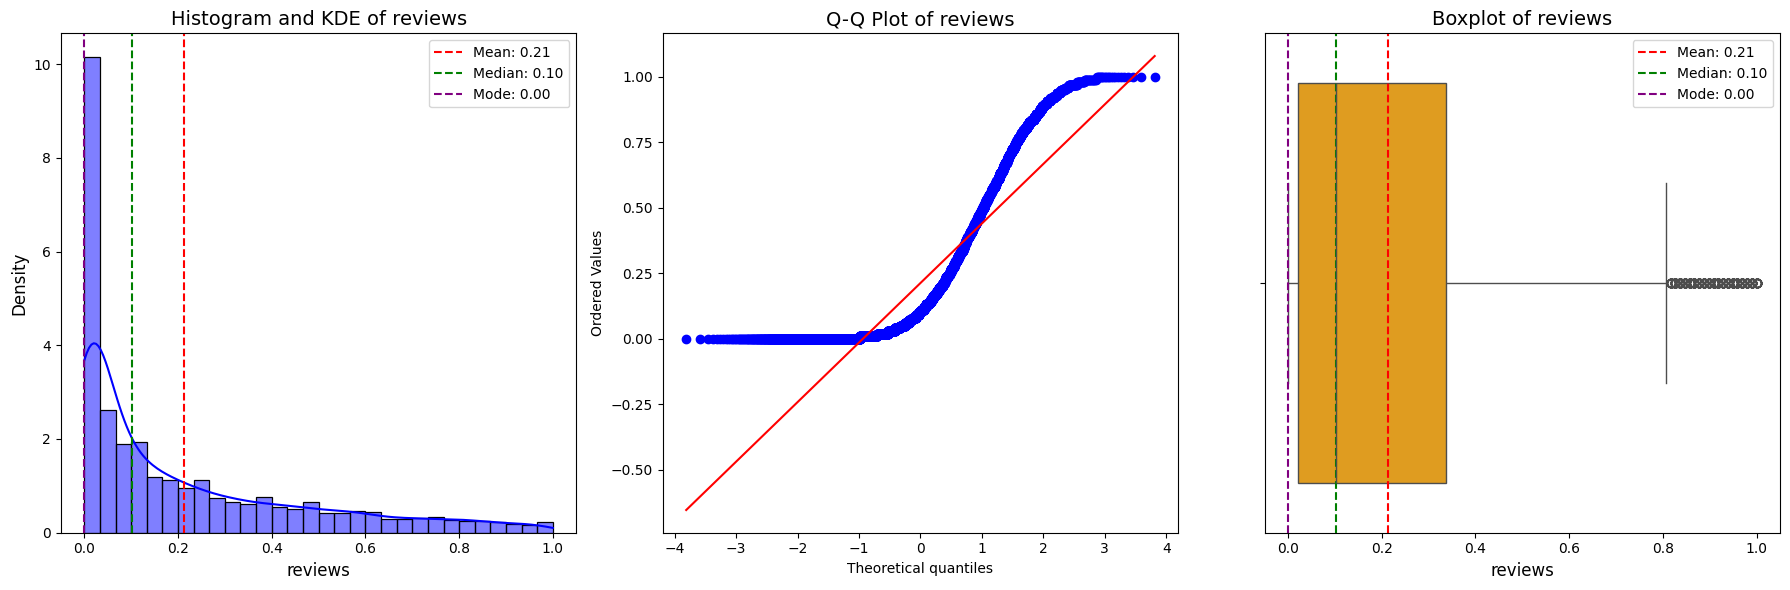


Normality Tests for Column: overall_satisfaction
Shapiro-Wilk Test: statistic=0.6694, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.3410, p-value=0.0000


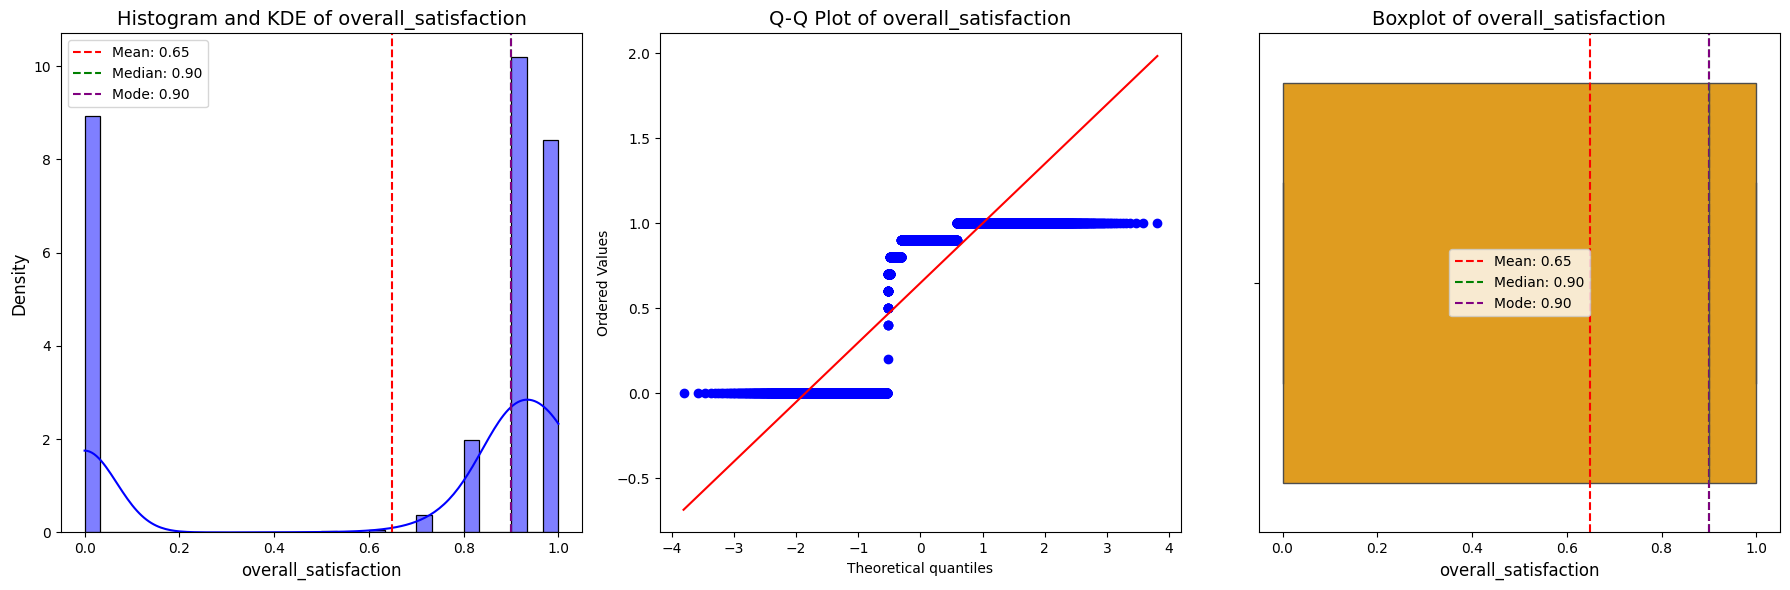


Normality Tests for Column: accommodates
Shapiro-Wilk Test: statistic=0.9016, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.2063, p-value=0.0000


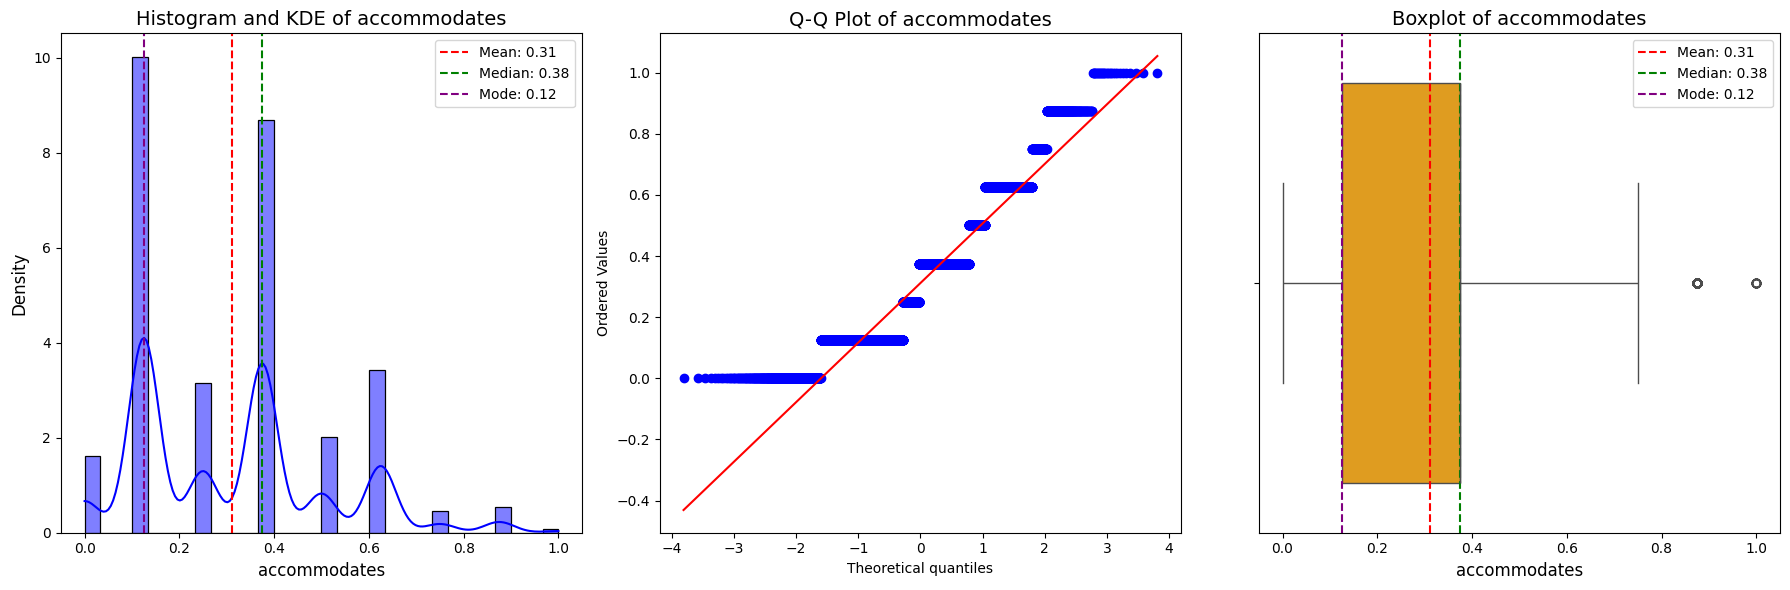


Normality Tests for Column: bedrooms
Shapiro-Wilk Test: statistic=0.7892, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.3535, p-value=0.0000


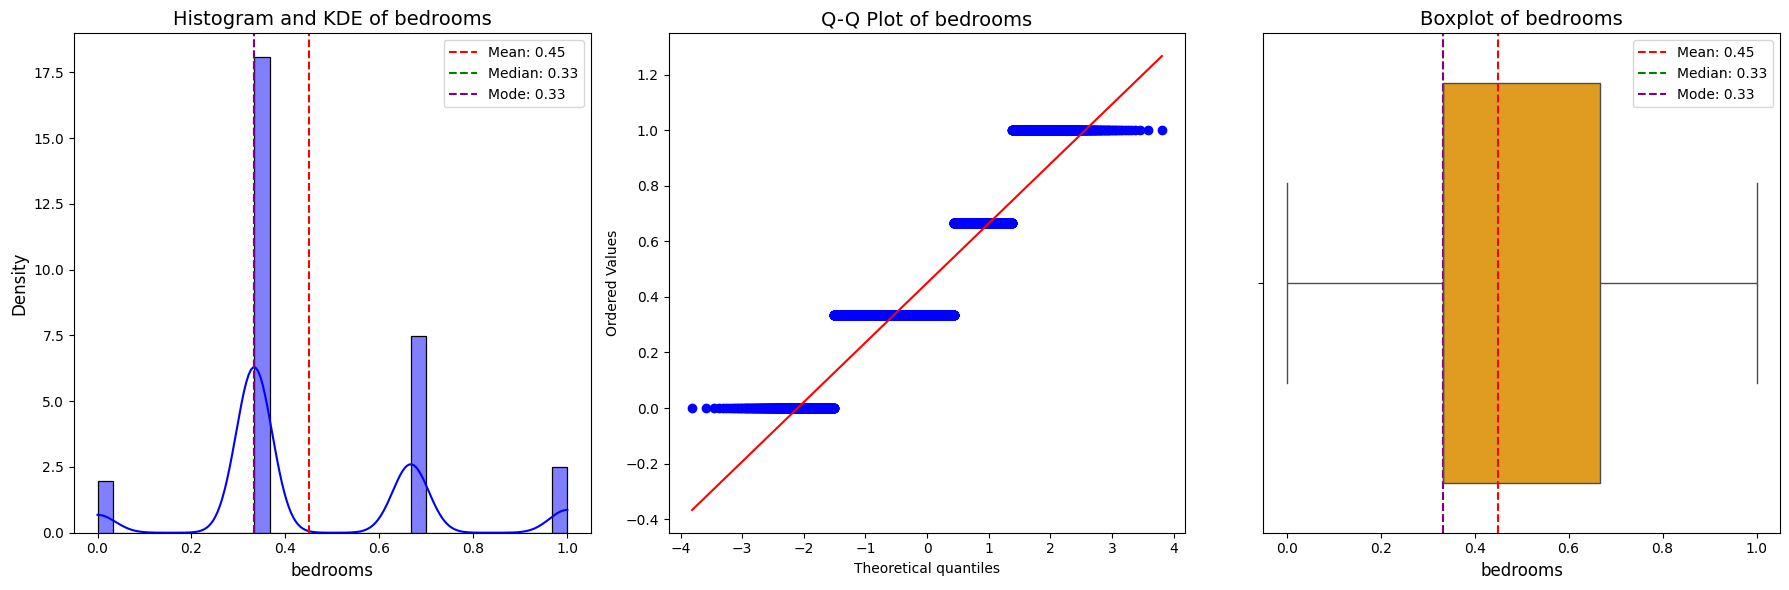


Normality Tests for Column: price
Shapiro-Wilk Test: statistic=0.9671, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.0897, p-value=0.0000


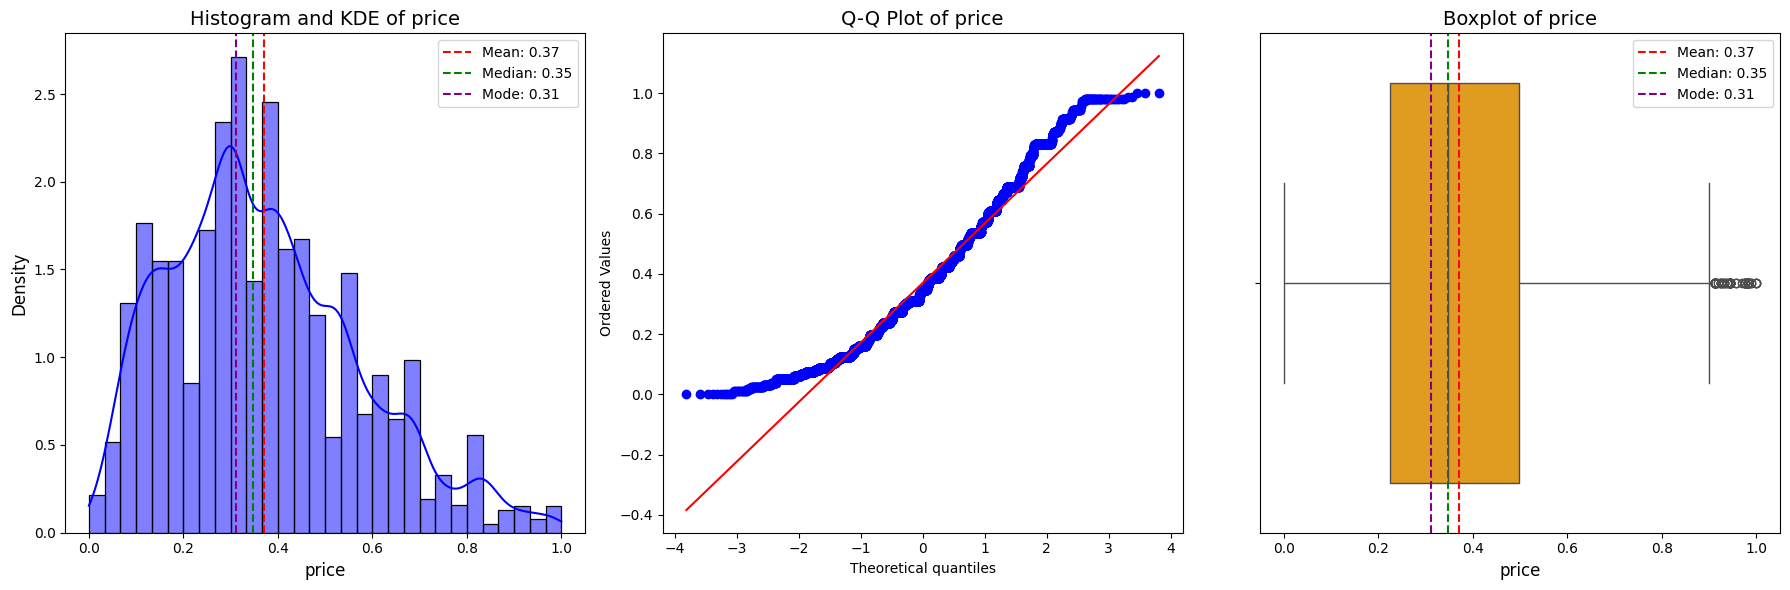


Normality Tests for Column: latitude
Shapiro-Wilk Test: statistic=0.9049, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.1308, p-value=0.0000


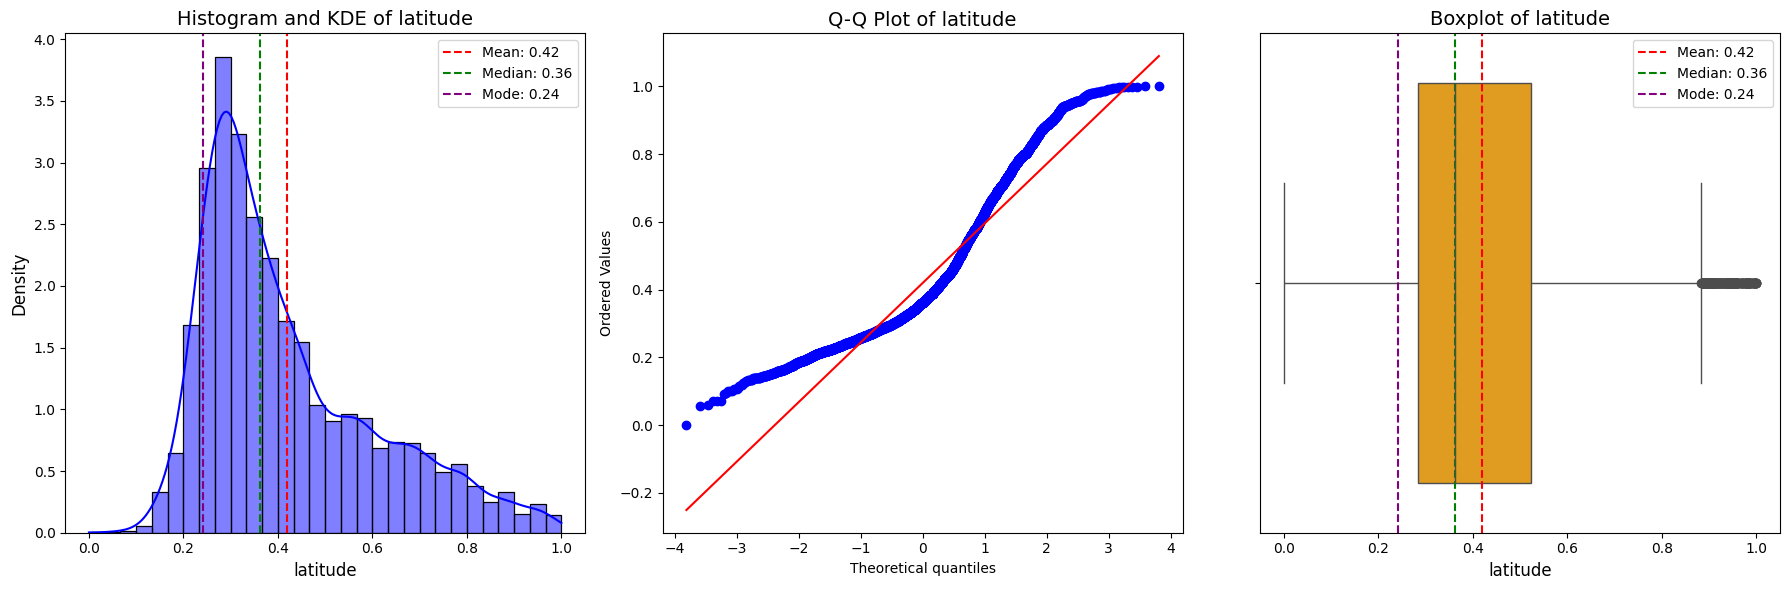


Normality Tests for Column: longitude
Shapiro-Wilk Test: statistic=0.9810, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.0681, p-value=0.0000


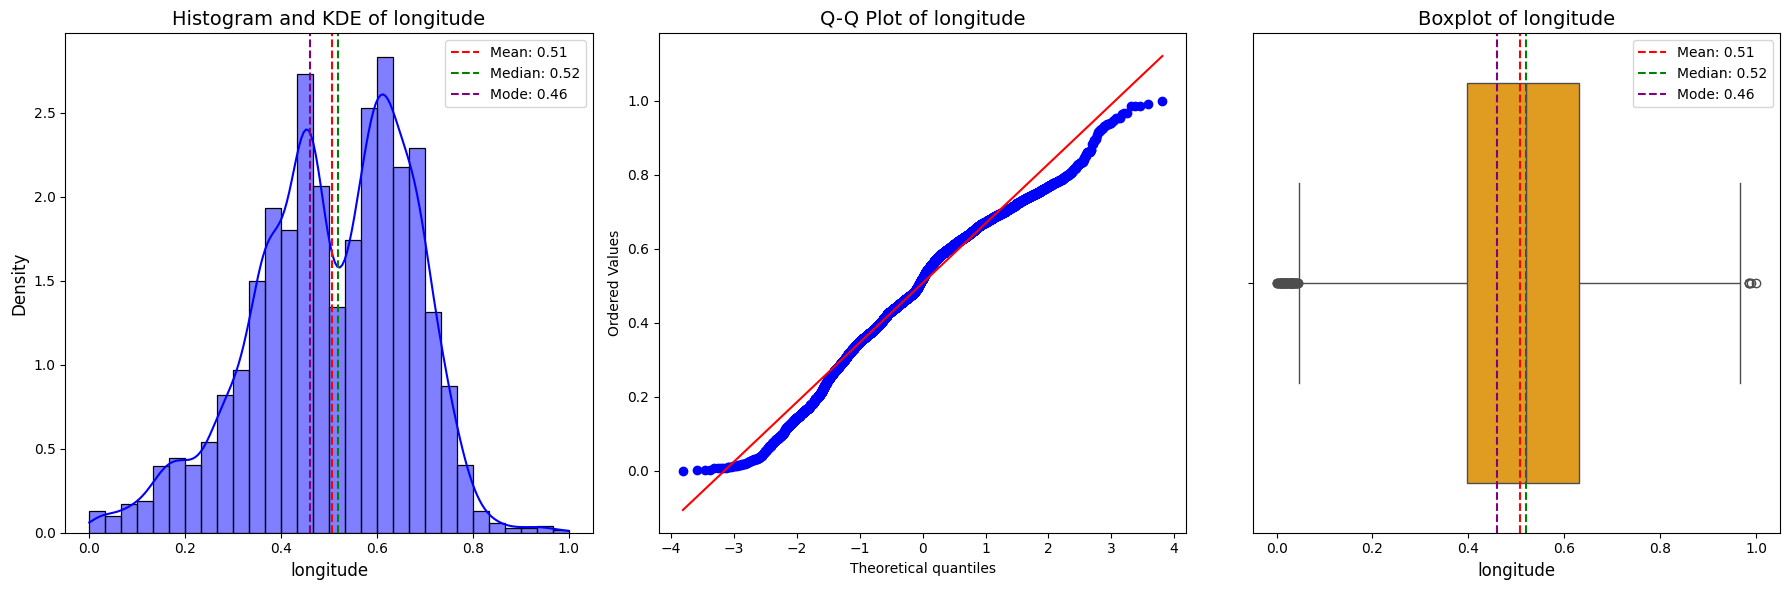

In [18]:
airbnb_data_prep.normality_test_with_plots()

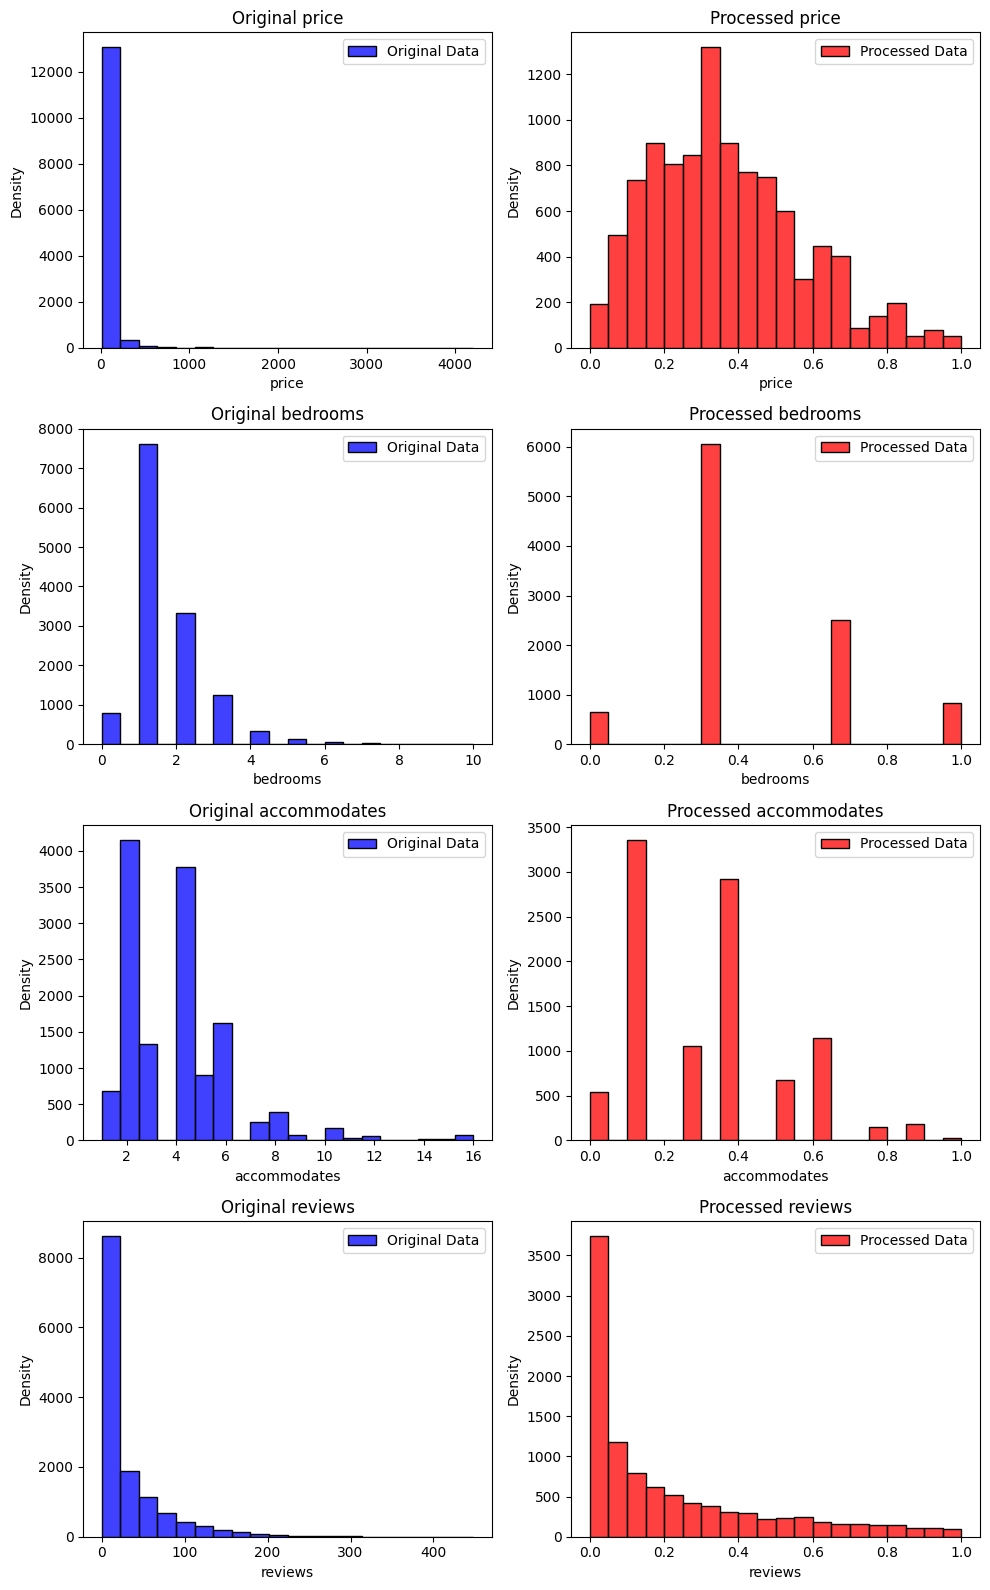

In [19]:
airbnb_data_prep.compare_data_state(columns=["price", "bedrooms", "accommodates","reviews"], bins=20, use_kde=False)

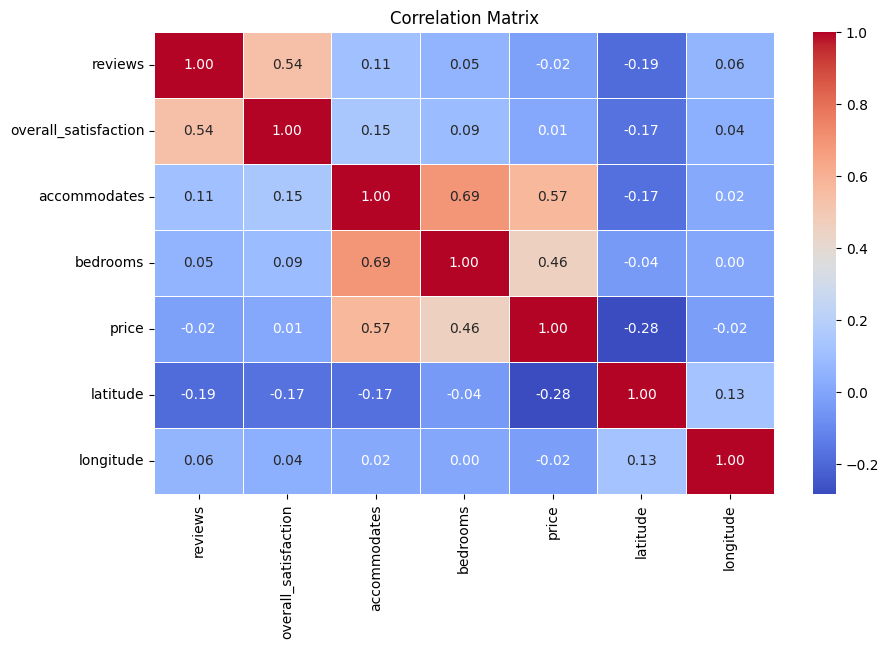

In [20]:
airbnb_data_prep.plot_correlation_matrix()

## Supervised Introduction

Supervised learning is a fundamental branch of machine learning where the goal is to learn a mapping between input features (predictors) and a known target variable (output) based on labeled training data. The model uses this learned relationship to make predictions on new, unseen data.

Advantages
- Provides accurate predictions when sufficient labeled data is available.
- Allows clear evaluation using well-defined metrics.
- Applicable to a wide range of real-world problems.

Limitations
- Requires large amounts of labeled data, which can be expensive or time-consuming to collect.
- Performance depends on the quality of the data and feature selection.
- May overfit to the training data if not properly regularized.

In [21]:
autoML = AutoMLPipeline(LearningType.SUPERVISED, TargetMetric.RMSE)
d_X, d_y = airbnb_data_prep.get_features_and_target()

autoML.train(TrainDataBuilder.supervised_train(d_X, d_y))

=== AutoML Report ===
Learning Type: supervised
Target Metric: rmse

Model: Random Forest
Best Score: -0.1439
Pipeline Steps:
  - preprocessor: ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['reviews', 'overall_satisfaction',
                                  'accommodates', 'bedrooms', 'latitude',
                                  'longitude']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])
  - model: RandomForestRegressor(max_depth=9, n_estimators=189)



Model: Linear Regression
Best Score: -0.1564
Pipeline Steps:
  - preprocessor: ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['reviews', 'overall_satisfaction',
                                  'accommodates', 'bedrooms', 'latitude',
                                  'longitude']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
           

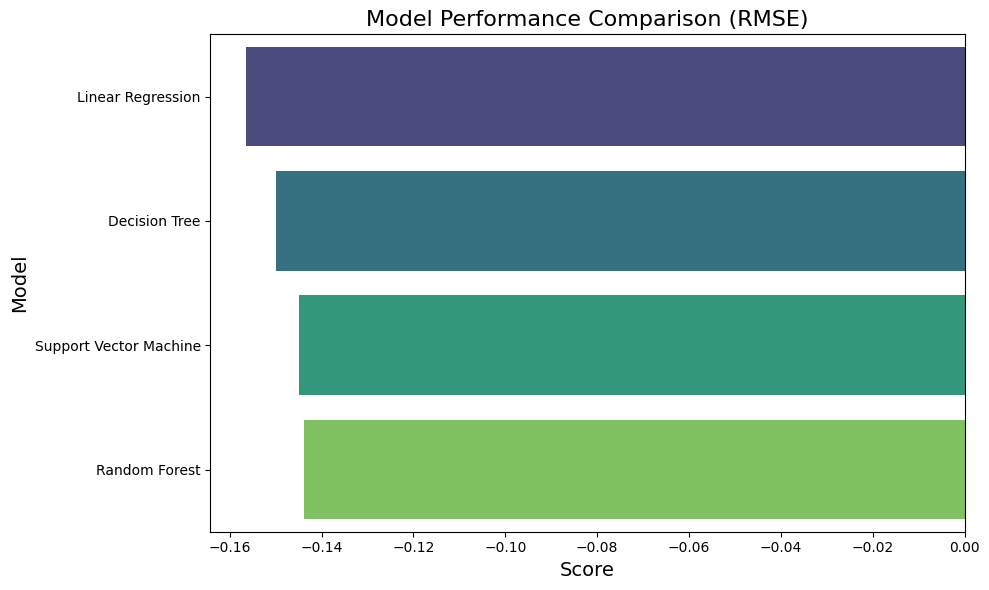


Best Model: Linear Regression with Score: -0.1564

Model: Random Forest | Score: -0.1439

Model: Linear Regression | Score: -0.1564

Model: Decision Tree | Score: -0.1499

Model: Support Vector Machine | Score: -0.1449


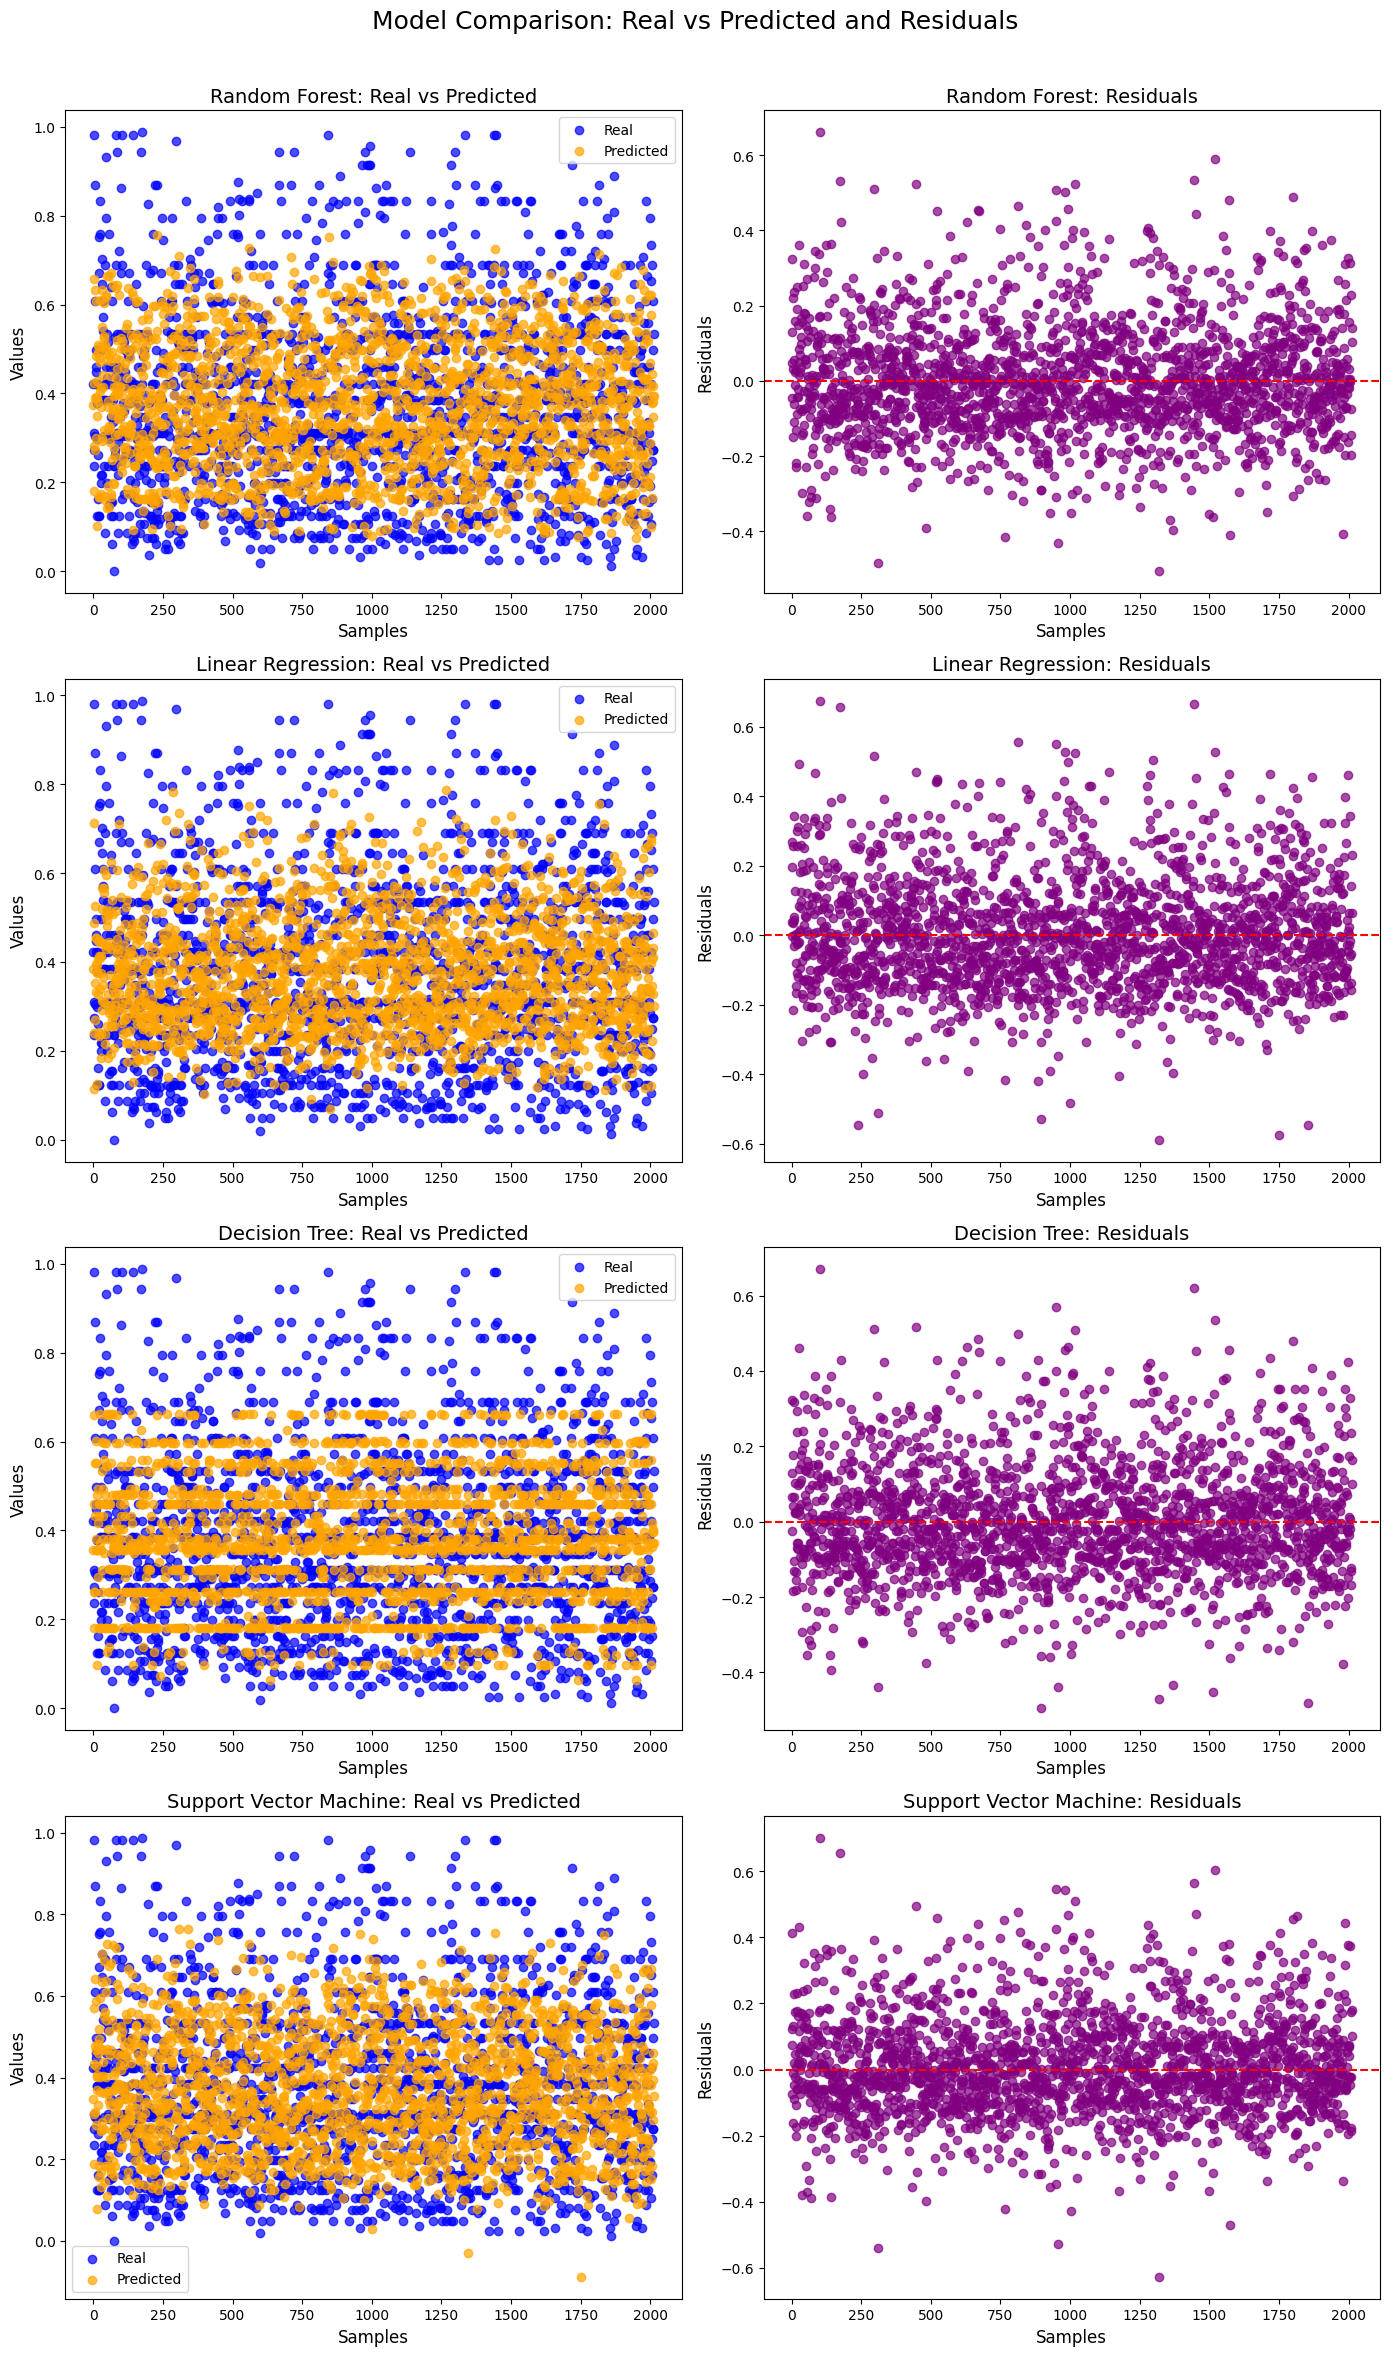

In [22]:
autoML.report()

## KMeans Introduction (Unsupervised)

K-Means is one of the most popular and widely used unsupervised machine learning algorithms. It is used for clustering, where the goal is to partition a dataset into distinct groups or clusters based on similarities in the data.

Advantages of K-Means
- Simple and computationally efficient.
- Works well for large datasets.
- Produces easily interpretable clusters.

Limitations
- Requires 𝑘 to be specified in advance.
- Sensitive to the initial placement of centroids (can lead to different results).
- Assumes clusters are spherical and of similar size, which may not hold in all datasets.
- Does not handle outliers well.

In [23]:
airbnb_data_prep:DataPreparation = DataPreparation("/content/airbnb_lisbon_1480_2017-07-27.csv", target_column="price")

Dataset Summary:
  Total Rows: 13578
  Total Columns: 20
  Total Missing Values: 54340 (20.01%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  Missing%  Dups  Uniques  Count  \
room_id                  int64         0  0.000000     0    13578  13578   
survey_id                int64         0  0.000000     0        1  13578   
host_id                  int64         0  0.000000     0     6457  13578   
room_type               object         0  0.000000     0        3  13578   
country                float64     13578  1.000000     0        0      0   
city                    object         0  0.000000     0        1  13578   
borough                float64     13578  1.000000     0        0      0   
neighborhood            object         0  0.000000     0       24  13578   
reviews                  int64         0  0.000000     0      276  13578   
overall_satisfaction   float64         0  0.000000     0        9  13578   
accommodates             int64         0  0.000000     0       16  13578   
bedrooms               float64         0  0.000000     0       11  13578   
bathrooms              float64     13578  1.000000     0        0      0   
price                  float64         0  0.000000     0      293  13578   
minstay                float64     13578  1.000000     0        0      0   
name                    object        28  0.002062     0    13350  13550   
last_modified           object         0  0.000000     0    13578  13578   
latitude               float64         0  0.000000     0    11079  13578   
longitude              float64         0  0.000000     0    11745  13578   
location                object         0  0.000000     0    13578  13578   

                            Min          Max          Average  \
room_id                  6499.0   20091030.0  11286530.758285   
survey_id                1480.0       1480.0           1480.0   
host_id                 14455.0  142658216.0  40317799.948814   
room_type                   NaN          NaN              NaN   
country                     NaN          NaN              NaN   
city                        NaN          NaN              NaN   
borough                     NaN          NaN              NaN   
neighborhood                NaN          NaN              NaN   
reviews                     0.0        448.0        29.507512   
overall_satisfaction        0.0          5.0         3.242046   
accommodates                1.0         16.0         3.872956   
bedrooms                    0.0         10.0         1.535793   
bathrooms                   NaN          NaN              NaN   
price                      10.0       4203.0        88.376712   
minstay                     NaN          NaN              NaN   
name                        NaN          NaN              NaN   
last_modified               NaN          NaN              NaN   
latitude              38.692112    38.792573        38.720882   
longitude             -9.226461     -9.09161        -9.143594   
location                    NaN          NaN              NaN   

                     Standard Deviation  \
room_id                  6331112.119502   
survey_id                           0.0   
host_id                 41202576.060598   
room_type                           NaN   
country                             NaN   
city                                NaN   
borough                             NaN   
neighborhood                        NaN   
reviews                       43.657402   
overall_satisfaction           2.151046   
accommodates                   2.254779   
bedrooms                       1.042837   
bathrooms                           NaN   
price                        123.044522   
minstay                             NaN   
name                                NaN   
last_modified                       NaN   
latitude                       0.015134   
longitude                      0.017923   
location                            NaN   

                                                            Value Row 1  \
room_id                                                        14708916   
surv

In [24]:
airbnb_data_prep.drop_columns([
	"room_id",
	"survey_id",
	"host_id",
	"last_modified",
	"name",
	"country",
	"city",
	"borough",
	"bathrooms",
	"minstay",
	"name",
	"last_modified",
	"latitude",
	"longitude",
	"location"
])

airbnb_data_prep.remove_outliers()
airbnb_data_prep.remove_duplicates(subset=None, keep="first")
airbnb_data_prep.handle_missing_values(data_type=DataClassification.CATEGORICAL, strategy=MissingValuesStrategy.MEAN, missing_threshold=0.7)

airbnb_data_prep.summary()

Columns room_id, survey_id, host_id, last_modified, name, country, city, borough, bathrooms, minstay, name, last_modified, latitude, longitude, location dropped successfully.
Using IQR method for skewed columns: ['reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'price']
Rows removed: 2294
Rows removed due to duplicates: 919
Dataset Summary:
  Total Rows: 10365
  Total Columns: 7
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  Missing%  Dups  Uniques  Count  \
room_type               object         0       0.0     0        3  10365   
neighborhood            object         0       0.0     0       24  10365   
reviews                  int64         0       0.0     0       99  10365   
overall_satisfaction   float64         0       0.0     0        9  10365   
accommodates             int64         0       0.0     0        9  10365   
bedrooms               float64         0       0.0     0        4  10365   
price                  float64         0       0.0     0      140  10365   

                       Min    Max    Average Standard Deviation  \
room_type              NaN    NaN        NaN                NaN   
neighborhood           NaN    NaN        NaN                NaN   
reviews                0.0   98.0  21.422865          24.569091   
overall_satisfaction   0.0    5.0   3.421563           2.060833   
accommodates           1.0    9.0   3.575591           1.648363   
bedrooms               0.0    3.0   1.380608           0.740403   
price                 10.0  171.0  70.279691          32.244256   

                        Value Row 1     Value Row 2        Value Row 3  
room_type               Shared room     Shared room        Shared room  
neighborhood          Santo António  Avenidas Novas  Santa Maria Maior  
reviews                          19               4                 38  
overall_satisfaction            4.5             3.5                4.5  
accommodates                      4               6                  8  
bedrooms                        1.0             1.0                1.0  
price                          30.0            39.0               39.0

In [25]:
airbnb_data_prep.encode_categorical()
airbnb_data_prep.summary()

One-hot encoding applied to columns: room_type, neighborhood
Dataset Summary:
  Total Rows: 10365
  Total Columns: 30
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  Missing%  Dups  \
reviews                                  int64         0       0.0     0   
overall_satisfaction                   float64         0       0.0     0   
accommodates                             int64         0       0.0     0   
bedrooms                               float64         0       0.0     0   
price                                  float64         0       0.0     0   
room_type_Private room                    bool         0       0.0     0   
room_type_Shared room                     bool         0       0.0     0   
neighborhood_Alcântara                    bool         0       0.0     0   
neighborhood_Alvalade                     bool         0       0.0     0   
neighborhood_Areeiro                      bool         0       0.0     0   
neighborhood_Arroios                      bool         0       0.0     0   
neighborhood_Avenidas Novas               bool         0       0.0     0   
neighborhood_Beato                        bool         0       0.0     0   
neighborhood_Belém                        bool         0       0.0     0   
neighborhood_Benfica                      bool         0       0.0     0   
neighborhood_Campo de Ourique             bool         0       0.0     0   
neighborhood_Campolide                    bool         0       0.0     0   
neighborhood_Carnide                      bool         0       0.0     0   
neighborhood_Estrela                      bool         0       0.0     0   
neighborhood_Lumiar                       bool         0       0.0     0   
neighborhood_Marvila                      bool         0       0.0     0   
neighborhood_Misericórdia                 bool         0       0.0     0   
neighborhood_Olivais                      bool         0       0.0     0   
neighborhood_Parque das Nações            bool         0       0.0     0   
neighborhood_Penha de França              bool         0       0.0     0   
neighborhood_Santa Clara                  bool         0       0.0     0   
neighborhood_Santa Maria Maior            bool         0       0.0     0   
neighborhood_Santo António                bool         0       0.0     0   
neighborhood_São Domingos de Benfica      bool         0       0.0     0   
neighborhood_São Vicente                  bool         0       0.0     0   

                                      Uniques  Count   Min    Max    Average  \
reviews                                    99  10365   0.0   98.0  21.422865   
overall_satisfaction                        9  10365   0.0    5.0   3.421563   
accommodates                                9  10365   1.0    9.0   3.575591   
bedrooms                                    4  10365   0.0    3.0   1.380608   
price                                     140  10365  10.0  171.0  70.279691   
room_type_Private room                      2  10365   NaN    NaN        NaN   
room_type_Shared room                       2  10365   NaN    NaN        NaN   
neighborhood_Alcântara                      2  10365   NaN    NaN        NaN   
neighborhood_Alvalade                       2  10365   NaN    NaN        NaN   
neighborhood_Areeiro                        2  10365   NaN    NaN        NaN   
neighborhood_Arroios                        2  10365   NaN    NaN        NaN   
neighborhood_Avenidas Novas                 2  10365   NaN    NaN        NaN   
neighborhood_Beato                          2  10365   NaN    NaN        NaN   
neighborhood_Belém                          2  10365   NaN    NaN        NaN   
neighborhood_Benfica                        2  10365   NaN    NaN        NaN   
neighborhood_Campo de Ourique               2  10365   NaN    NaN        NaN   
neighborhood_Campolide                      2  10365   NaN    NaN        NaN   
neighborhood_Carnide                        2  10365   NaN    NaN        NaN   
neighborhood_Estrela                        2  10365   NaN    NaN        NaN   
neighborhood_Lumiar                         2  10365   NaN    NaN        NaN   


In [26]:
airbnb_data_prep.scale_features()
airbnb_data_prep.summary()

Dataset Summary:
  Total Rows: 10365
  Total Columns: 30
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  Missing%  Dups  \
reviews                                float64         0       0.0     0   
overall_satisfaction                   float64         0       0.0     0   
accommodates                           float64         0       0.0     0   
bedrooms                               float64         0       0.0     0   
price                                  float64         0       0.0     0   
room_type_Private room                    bool         0       0.0     0   
room_type_Shared room                     bool         0       0.0     0   
neighborhood_Alcântara                    bool         0       0.0     0   
neighborhood_Alvalade                     bool         0       0.0     0   
neighborhood_Areeiro                      bool         0       0.0     0   
neighborhood_Arroios                      bool         0       0.0     0   
neighborhood_Avenidas Novas               bool         0       0.0     0   
neighborhood_Beato                        bool         0       0.0     0   
neighborhood_Belém                        bool         0       0.0     0   
neighborhood_Benfica                      bool         0       0.0     0   
neighborhood_Campo de Ourique             bool         0       0.0     0   
neighborhood_Campolide                    bool         0       0.0     0   
neighborhood_Carnide                      bool         0       0.0     0   
neighborhood_Estrela                      bool         0       0.0     0   
neighborhood_Lumiar                       bool         0       0.0     0   
neighborhood_Marvila                      bool         0       0.0     0   
neighborhood_Misericórdia                 bool         0       0.0     0   
neighborhood_Olivais                      bool         0       0.0     0   
neighborhood_Parque das Nações            bool         0       0.0     0   
neighborhood_Penha de França              bool         0       0.0     0   
neighborhood_Santa Clara                  bool         0       0.0     0   
neighborhood_Santa Maria Maior            bool         0       0.0     0   
neighborhood_Santo António                bool         0       0.0     0   
neighborhood_São Domingos de Benfica      bool         0       0.0     0   
neighborhood_São Vicente                  bool         0       0.0     0   

                                      Uniques  Count  Min  Max   Average  \
reviews                                    99  10365  0.0  1.0  0.218601   
overall_satisfaction                        9  10365  0.0  1.0  0.684313   
accommodates                                9  10365  0.0  1.0  0.321949   
bedrooms                                    4  10365  0.0  1.0  0.460203   
price                                     140  10365  0.0  1.0  0.374408   
room_type_Private room                      2  10365  NaN  NaN       NaN   
room_type_Shared room                       2  10365  NaN  NaN       NaN   
neighborhood_Alcântara                      2  10365  NaN  NaN       NaN   
neighborhood_Alvalade                       2  10365  NaN  NaN       NaN   
neighborhood_Areeiro                        2  10365  NaN  NaN       NaN   
neighborhood_Arroios                        2  10365  NaN  NaN       NaN   
neighborhood_Avenidas Novas                 2  10365  NaN  NaN       NaN   
neighborhood_Beato                          2  10365  NaN  NaN       NaN   
neighborhood_Belém                          2  10365  NaN  NaN       NaN   
neighborhood_Benfica                        2  10365  NaN  NaN       NaN   
neighborhood_Campo de Ourique               2  10365  NaN  NaN       NaN   
neighborhood_Campolide                      2  10365  NaN  NaN       NaN   
neighborhood_Carnide                        2  10365  NaN  NaN       NaN   
neighborhood_Estrela                        2  10365  NaN  NaN       NaN   
neighborhood_Lumiar                         2  10365  NaN  NaN       NaN   
neighborhood_Marvila                        2  10365  NaN  NaN       NaN   
neighbor

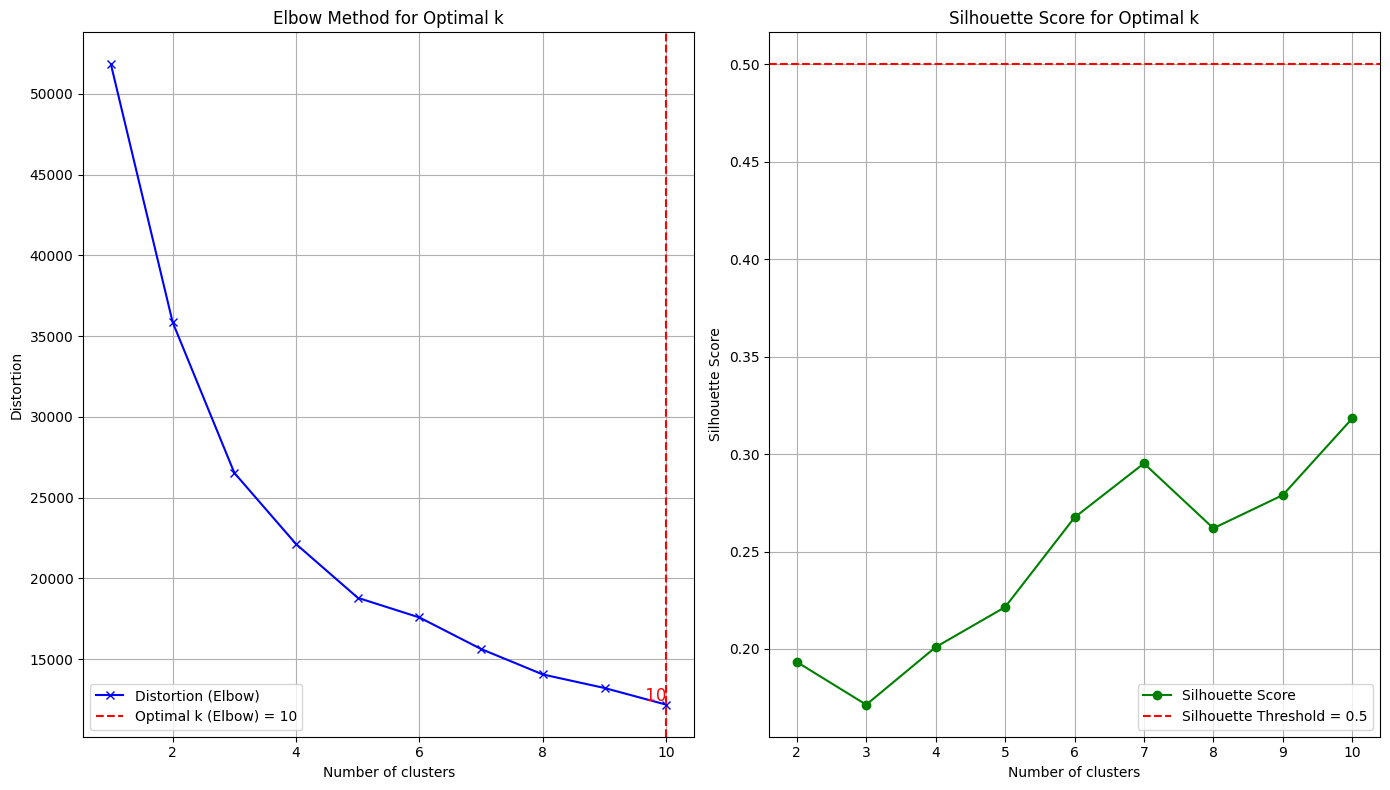

Model trained with k=5


In [30]:
uautoML = AutoMLPipeline(LearningType.UNSUPERVISED)
uautoML.train(TrainDataBuilder.unsupervised_train(airbnb_data_prep.df, manual_k=5))

=== AutoML Report ===
Learning Type: unsupervised
Target Metric: Not applicable (Unsupervised Learning)

Model: KMeans
Best Score: -18789.8759
Pipeline Steps:
  - preprocessor: ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['reviews', 'overall_satisfaction',
                                  'accommodates', 'bedrooms', 'price']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 [])])
  - model: KMeans(n_clusters=5, random_state=42)



Model Performance Summary:
    Model         Score  Rank
0  KMeans -18789.875897   1.0


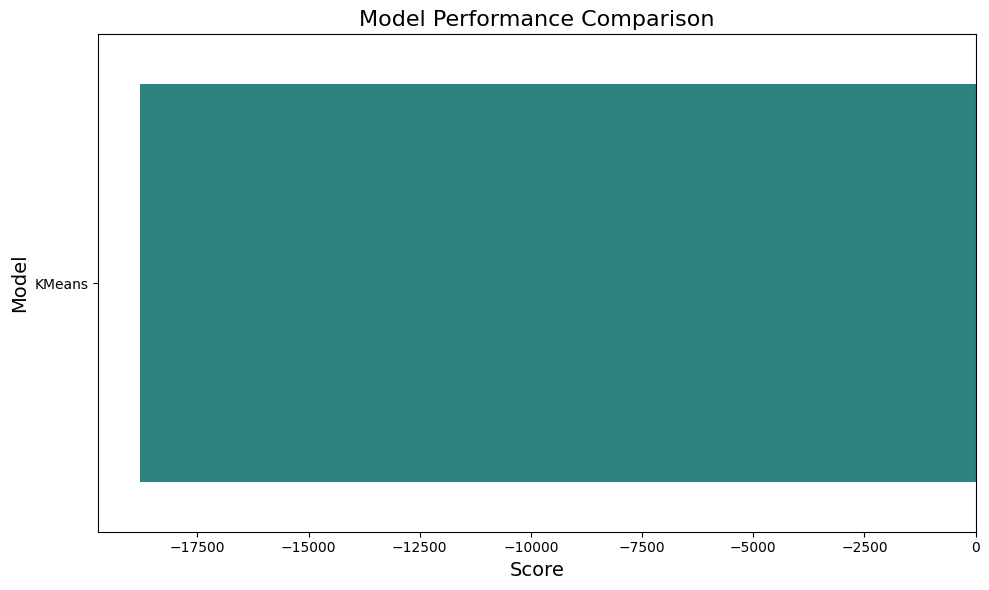


Best Model: KMeans with Score: -18789.8759
Index(['reviews', 'overall_satisfaction', 'accommodates', 'bedrooms', 'price',
       'room_type_Private room', 'room_type_Shared room',
       'neighborhood_Alcântara', 'neighborhood_Alvalade',
       'neighborhood_Areeiro', 'neighborhood_Arroios',
       'neighborhood_Avenidas Novas', 'neighborhood_Beato',
       'neighborhood_Belém', 'neighborhood_Benfica',
       'neighborhood_Campo de Ourique', 'neighborhood_Campolide',
       'neighborhood_Carnide', 'neighborhood_Estrela', 'neighborhood_Lumiar',
       'neighborhood_Marvila', 'neighborhood_Misericórdia',
       'neighborhood_Olivais', 'neighborhood_Parque das Nações',
       'neighborhood_Penha de França', 'neighborhood_Santa Clara',
       'neighborhood_Santa Maria Maior', 'neighborhood_Santo António',
       'neighborhood_São Domingos de Benfica', 'neighborhood_São Vicente'],
      dtype='object')

Model: KMeans | Silhouette Score: -18789.8759

Cluster Summary (Mean, Std, Size) for pr

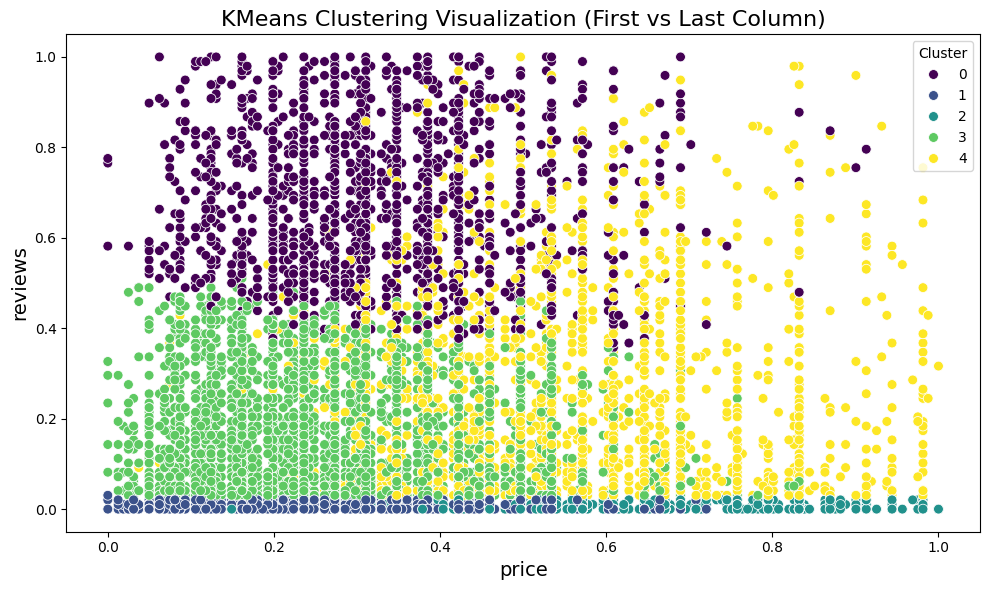


Cluster 3 Statistics for price and reviews:
             price      reviews
count  3573.000000  3573.000000
mean      0.276656     0.164316
std       0.143115     0.115069
min       0.000000     0.030612
25%       0.161491     0.061224
50%       0.273292     0.132653
75%       0.378882     0.244898
max       0.832298     0.510204


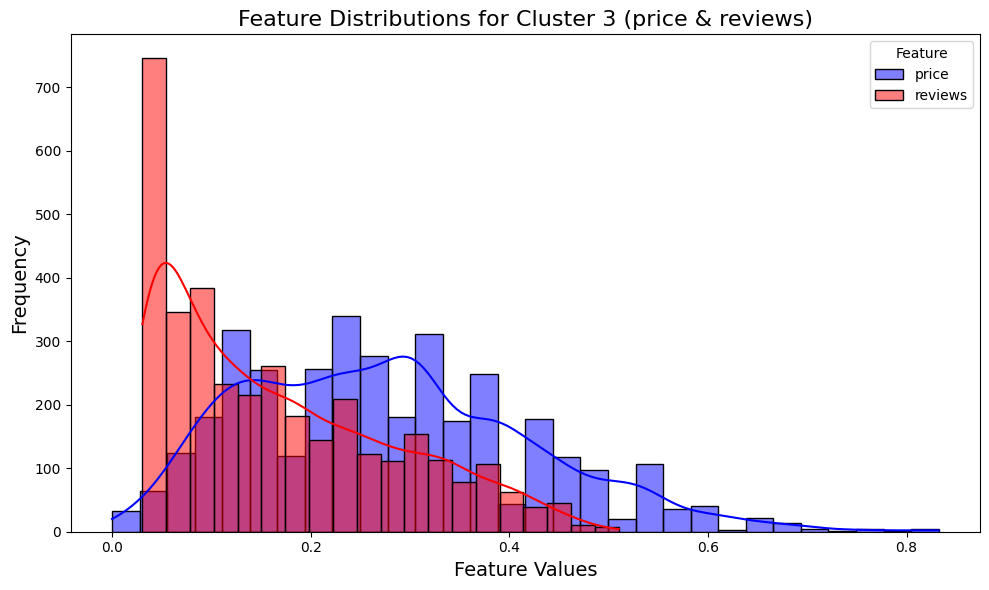


Cluster 4 Statistics for price and reviews:
             price      reviews
count  2470.000000  2470.000000
mean      0.523733     0.235797
std       0.178750     0.199225
min       0.031056     0.030612
25%       0.385093     0.081633
50%       0.496894     0.173469
75%       0.645963     0.346939
max       1.000000     1.000000


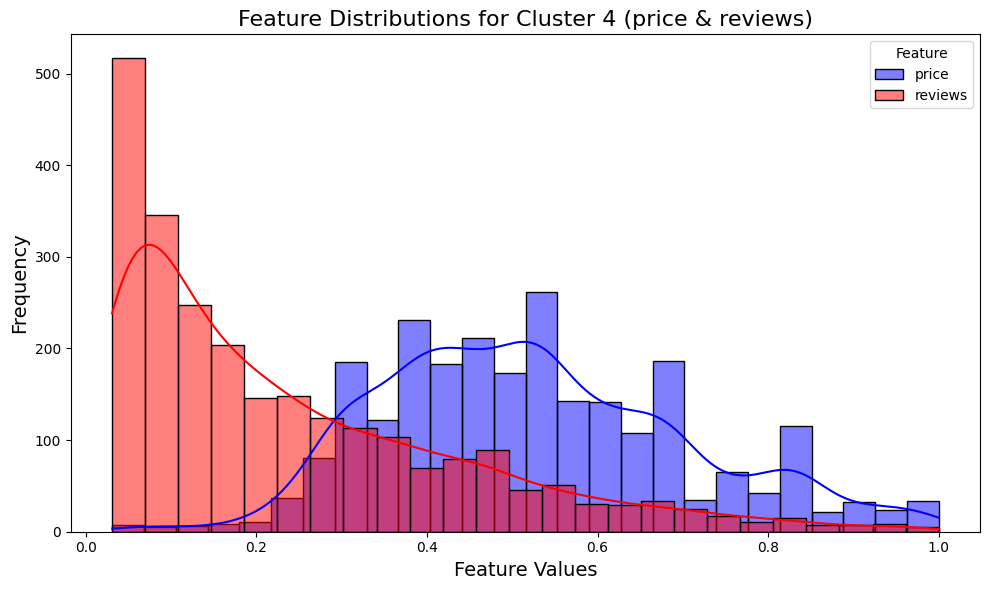


Cluster 2 Statistics for price and reviews:
             price      reviews
count  1020.000000  1020.000000
mean      0.591323     0.007273
std       0.180698     0.008255
min       0.031056     0.000000
25%       0.459627     0.000000
50%       0.571429     0.000000
75%       0.689441     0.010204
max       1.000000     0.030612


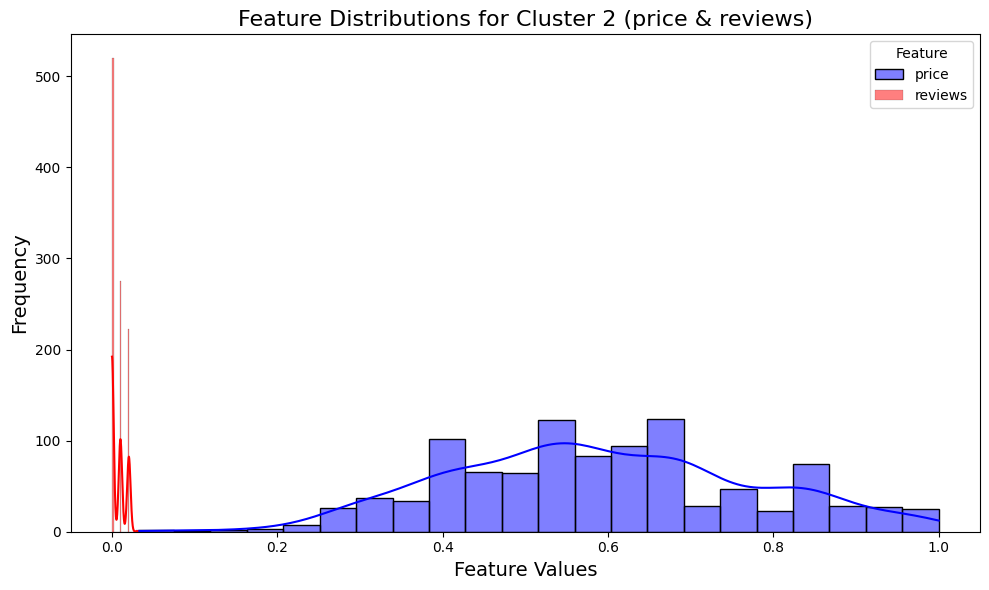


Cluster 1 Statistics for price and reviews:
             price      reviews
count  1696.000000  1696.000000
mean      0.283019     0.006883
std       0.162065     0.008063
min       0.000000     0.000000
25%       0.149068     0.000000
50%       0.273292     0.000000
75%       0.385093     0.010204
max       0.981366     0.040816


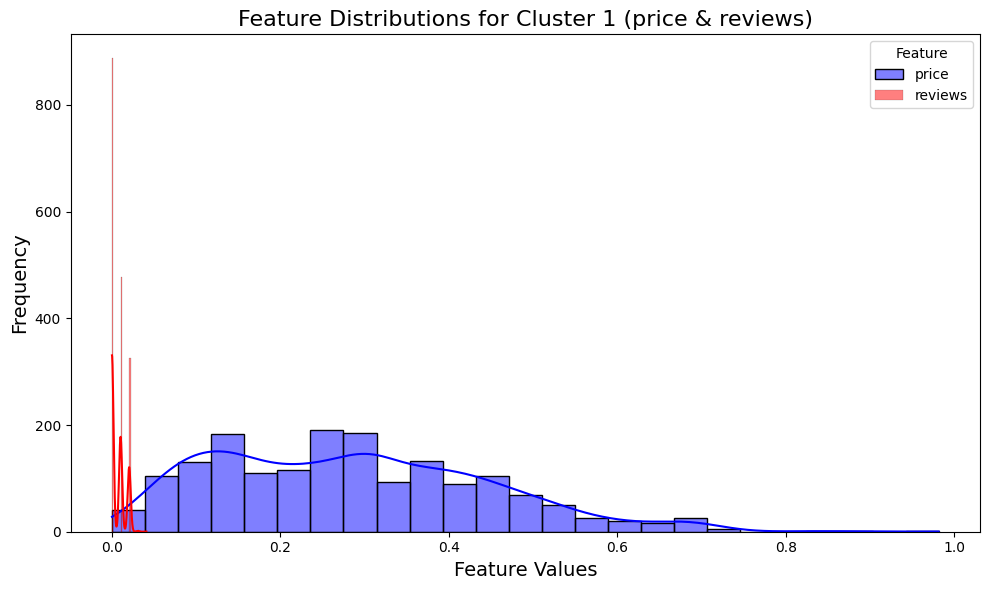


Cluster 0 Statistics for price and reviews:
             price      reviews
count  1606.000000  1606.000000
mean      0.320970     0.670725
std       0.136484     0.167091
min       0.000000     0.346939
25%       0.236025     0.530612
50%       0.310559     0.653061
75%       0.391304     0.806122
max       0.913043     1.000000


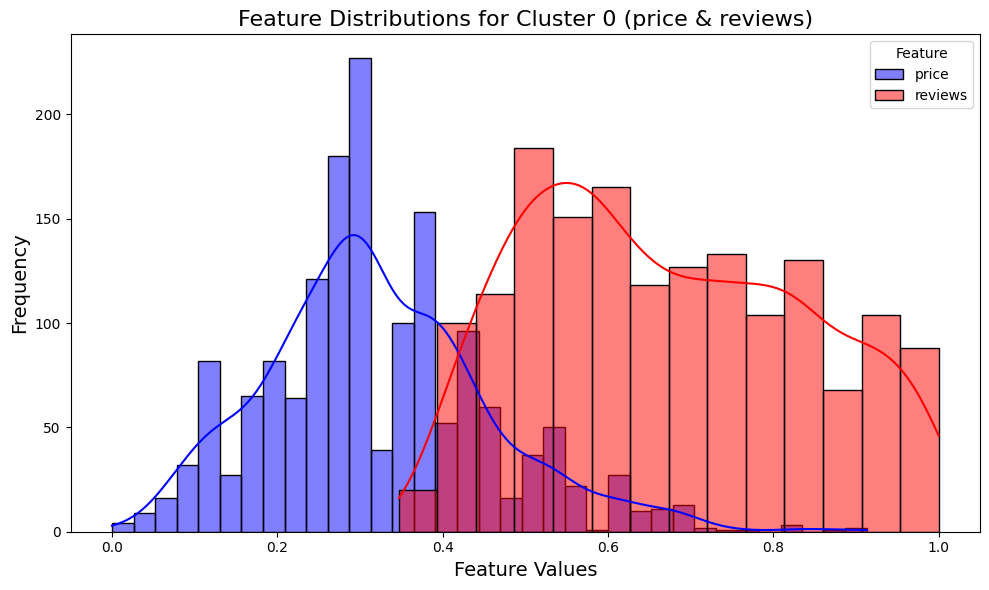

In [33]:
uautoML.report(target_columns=["price", "reviews"])

### Results and Conclusions (KMeans)

- _Cluster 0_ Represents listings with strong customer feedback and affordable pricing, likely indicating high value for money.
- _Cluster 1_ Indicates listings with minimal engagement and budget-friendly pricing, possibly less popular or new.
- _Cluster 2_ Suggests premium-priced listings with limited customer feedback, potentially targeting niche or luxury segments.
- _Cluster 3_ Represents moderately popular listings with balanced pricing, appealing to average customers.
- _Cluster 4_ Likely captures premium listings with good engagement, attracting customers willing to pay more for quality.

Strategies should focus on amplifying Cluster 2’s influence, nurturing Cluster 0’s engagement, and investigating Cluster 1’s potential to enhance their contribution.

## APRIORI Introduction (Unsupervised)

The Apriori algorithm is a popular method in data mining for extracting frequent itemsets and generating association rules from transactional data. It is widely used in market basket analysis to uncover relationships between items frequently purchased together.

Advantages of the Apriori Algorithm
- Simple and intuitive.
- Leverages the Apriori property to reduce computational complexity.
- Works well for small to medium-sized datasets.

Limitations
- Can be computationally expensive for large datasets with many items.
- Requires setting thresholds (e.g., support, confidence), which may affect the results if chosen incorrectly.
- Generates a large number of rules, some of which may not be meaningful.


The challenge is to refine the dataset and analysis to uncover more nuanced and actionable insights about customer purchasing behavior. Specifically, the goal is to identify unique associations, trends, or patterns that can better inform marketing strategies, inventory management, and targeted promotions.

In [ ]:
import kagglehub

dataset_path = "mohammadtalib786/retail-sales-dataset"
!kaggle datasets download {dataset_path} -p /content/ --unzip

retail_sales:DataPreparation = DataPreparation("/content/retail_sales_dataset.csv")

Dataset Summary:
  Total Rows: 1000
  Total Columns: 9
  Total Missing Values: 0 (0.00%)
  Total Duplicated Rows: 0

Column-wise Summary:


Data Type  Missing#  Missing%  Dups  Uniques  Count   Min  \
Transaction ID       int64         0       0.0     0     1000   1000   1.0   
Date                object         0       0.0     0      345   1000   NaN   
Customer ID         object         0       0.0     0     1000   1000   NaN   
Gender              object         0       0.0     0        2   1000   NaN   
Age                  int64         0       0.0     0       47   1000  18.0   
Product Category    object         0       0.0     0        3   1000   NaN   
Quantity             int64         0       0.0     0        4   1000   1.0   
Price per Unit       int64         0       0.0     0        5   1000  25.0   
Total Amount         int64         0       0.0     0       18   1000  25.0   

                     Max Average Standard Deviation Value Row 1 Value Row 2  \
Transaction ID    1000.0   500.5         288.819436           1           2   
Date                 NaN     NaN                NaN  2023-11-24  2023-02-27   
Customer ID          NaN     NaN                NaN     CUST001     CUST002   
Gender               NaN     NaN                NaN        Male      Female   
Age                 64.0  41.392           13.68143          34          26   
Product Category     NaN     NaN                NaN      Beauty    Clothing   
Quantity             4.0   2.514           1.132734           3           2   
Price per Unit     500.0  179.89         189.681356          50         500   
Total Amount      2000.0   456.0         559.997632         150        1000   

                  Value Row 3  
Transaction ID              3  
Date               2023-01-13  
Customer ID           CUST003  
Gender                   Male  
Age                        50  
Product Category  Electronics  
Quantity                    1  
Price per Unit             30  
Total Amount               30

Aggregated Data:
   Age Product Category  Quantity
0   18           Beauty        24
1   18         Clothing        19
2   18      Electronics        11
3   19           Beauty        18
4   19         Clothing         8
Pivoted Data:
Product Category  Beauty  Clothing  Electronics
Age                                            
18                    24        19           11
19                    18         8           31
20                    18        11           18
21                    25        18            7
22                    24        23           18
Binary Data for Apriori:
Product Category  Beauty  Clothing  Electronics
Age                                            
18                     1         1            1
19                     1         1            1
20                     1         1            1
21                     1         1            1
22                     1         1            1
Frequent Itemsets:
   support                         itemsets
0    

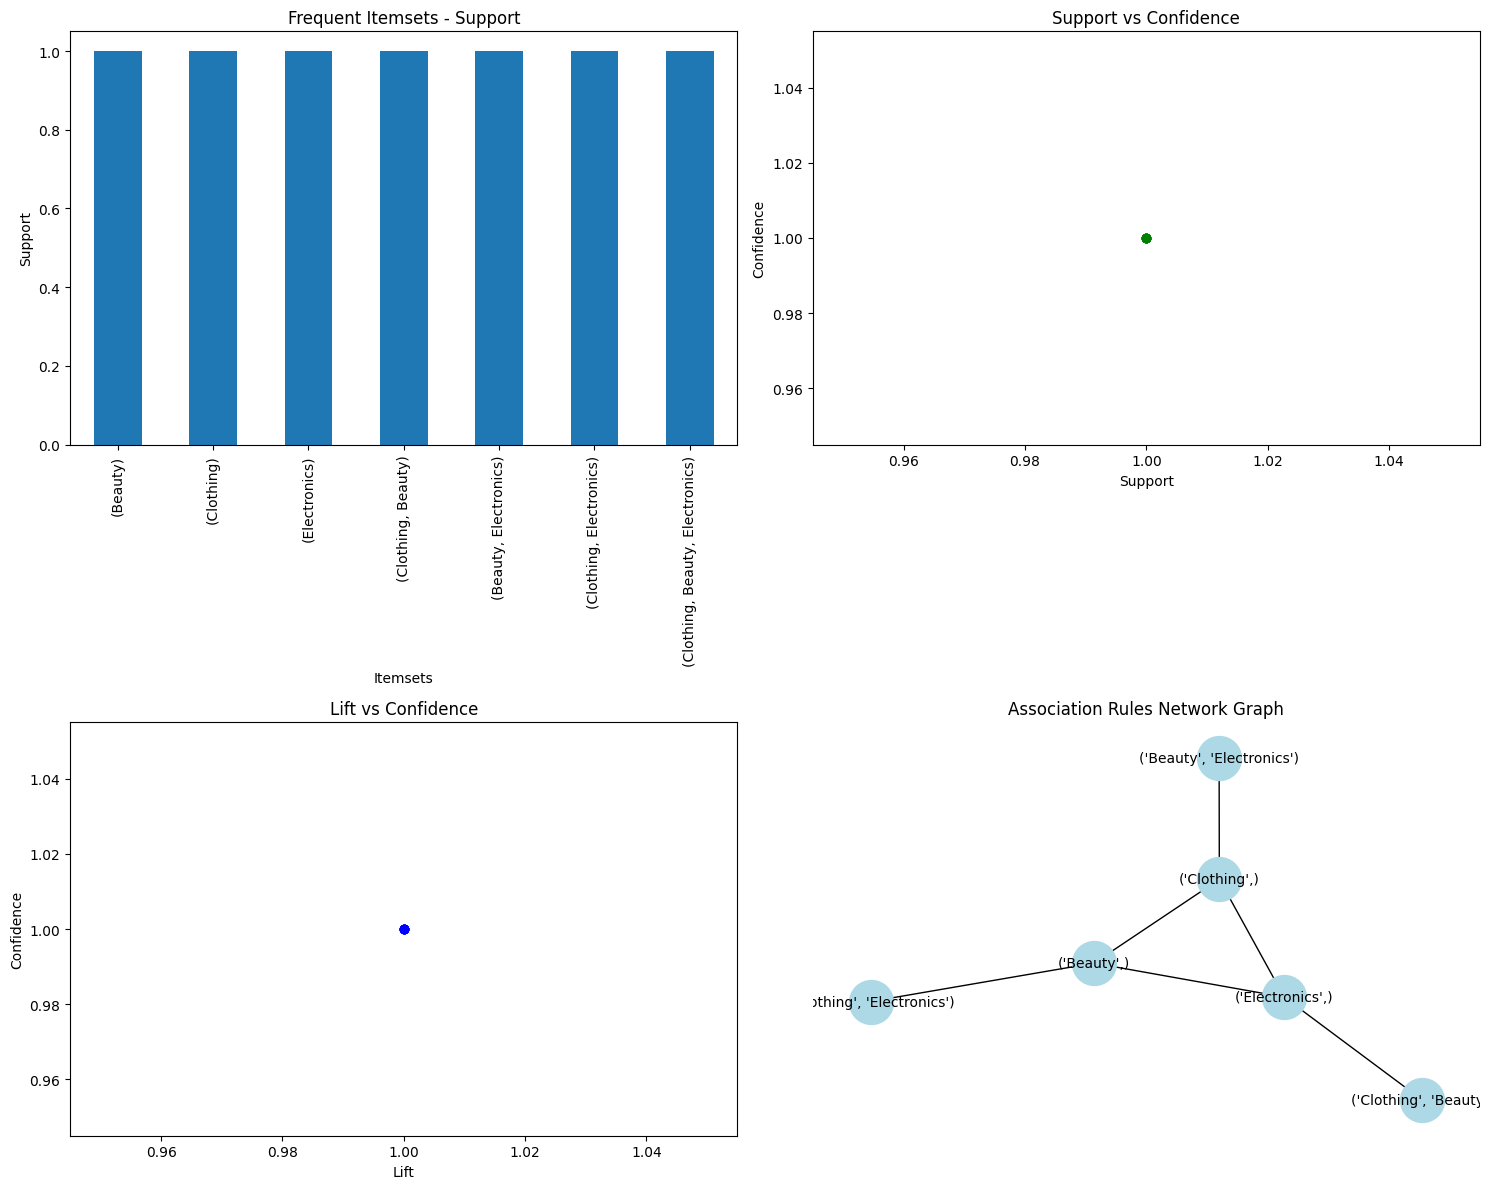

In [37]:
autoMLApriori = AutoMLPipeline(LearningType.APRIORI)
autoMLApriori.train(TrainDataBuilder.apriori_train(x=retail_sales.df,group_columns=["Age", "Product Category"], agg_column="Quantity"))

### Results and Conclusions (APRIORI)

1. Support:
The support value of 1.0 for all itemsets implies that every itemset appears in 100% of the transactions (in this case, "Age" groups).
For example, (Beauty) has a support of 1.0, meaning all age groups (18 to 22) purchased items in the "Beauty" category.

2. Itemsets:
These represent combinations of product categories frequently bought together by the age groups:
(Beauty), (Clothing), (Electronics): Individual categories frequently bought across all age groups.
(Beauty, Clothing): Indicates that items from both categories were bought together across all age groups.
(Electronics, Beauty), (Electronics, Clothing): Combinations of two categories frequently bought together.
(Electronics, Beauty, Clothing): All three categories were bought together by every age group.

3. Interpretation:
The data suggests there is no variation in buying behavior among the different age groups. Every group purchased items from all three categories.
Since the binary data shows all values as 1, the algorithm treats every combination of product categories as equally frequent.

4. Insights:
The frequent itemsets and their high support indicate strong cross-category purchasing habits, but this result may not provide actionable insights due to the uniformity in data (binary data is all 1s).
If you need more nuanced insights, consider refining the data (e.g., by incorporating thresholds for support, excluding categories with low relevance, or analyzing based on actual purchase amounts).